In [1]:
import os
import glob
import itertools
import json
import importlib
import copy

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl

In [8]:
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.correlations as cr
import analyze2p.scatter as sct

import analyze2p.objects.sim_utils as su

In [3]:
%matplotlib notebook

In [4]:
# import sys
# !{sys.executable} -m pip install shapely

# Source data

In [5]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

## Metdata

In [6]:
# Load RF fit params for good rois
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# cells, missing_seg = aggr.get_cells_by_area(sdata, return_missing=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
|    |   visual_area |
|:---|--------------:|
| V1 |            18 |
| Li |            15 |
| Lm |            15 |


## Select data and output

In [7]:
# Load trial metrics
experiment='rfs'
trial_epoch = 'stimulus'
traceid='traces001'
response_type='dff'
responsive_test='nstds'
responsive_thr=7
# ---------------------------------------------
responsive_str = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
Stimulus: rfs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          1766 |
| Lm |          1366 |
| Li |           797 |


## Load RF fits

In [18]:
# experiment = 'rfs'
response_type='dff'
do_spherical_correction=False
reliable_only=True
pass_criterion=['position', 'size']
combine_method = 'select'
# ---------------------------------------------------------------
# Get RF fit description (tag for which RF analysis to load)
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(CELLS,meta,
                        response_type=response_type,
                        do_spherical_correction=do_spherical_correction,
                        reliable_only=reliable_only, pass_criterion=pass_criterion,
                        combine=combine_method, ecc_center=(0, 20))
# Add ROI positions
rfdf = aggr.add_roi_positions(rfdf.copy())
# Get polygons
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
except FileNotFoundError as e:
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=True)
    
# data id
rf_correction_str = 'sphrcorr' if do_spherical_correction else 'uncorr'
rf_str = 'rfs-%s-%s' % (response_type, rf_correction_str)
reliable_str = 'reliable_%s' % combine_method if reliable_only \
                    else 'allfits_%s' % combine_method

data_id = '|'.join([traceid, responsive_str, rf_str, reliable_str])
print(data_id)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4
traces001|dff_responsive-nstds-thr7.00|rfs-dff-uncorr|reliable_select


In [19]:
# Set output dir
rf_type = 'rfs_sphrcorr' if do_spherical_correction else 'rfs_uncorr'
corr_dir = os.path.join(aggregate_dir, 'correlations', 
                       'rfs_%s_%s' % (response_type, responsive_test))
dst_dir = os.path.join(corr_dir, '%s_metrics' % rf_type)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

examples_dir = os.path.join(dst_dir, 'examples')
if not os.path.exists(examples_dir):
    os.makedirs(examples_dir)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES','correlations')
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics


## Add projection and scatter info

In [20]:
ecc_center=(0, 20)
no_rfs=[]; bad_fits=[];
a_list=[]
for (va, dk, exp), g in rfdf.groupby(['visual_area', 'datakey', 'experiment']):
    regr_np = sct.load_models(dk, va)
    aligned_ = sct.predict_soma_from_gradient(dk, va, regr_np, experiment=exp,
                                response_type=response_type,ecc_center=ecc_center,
                                do_spherical_correction=do_spherical_correction)
    if (regr_np['R2']<0.5).values.all():
        bad_fits.append((va, dk, exp))
        continue
    if aligned_ is None:
        no_rfs.append((va, dk, exp))
        continue
    for p in ['R2', 'RMSE', 'coefficient', 'intercept']:
        r2_ml = float(regr_np[regr_np.cond=='az'][p])
        r2_ap = float(regr_np[regr_np.cond=='el'][p])
        aligned_['gradient_%s_ml' % p] = r2_ml
        aligned_['gradient_%s_ap' % p] = r2_ap
    aligned_['visual_area']==va
    aligned_['datakey'] = dk
    aligned_['experiment'] = exp
    a_list.append(aligned_)
aligned_soma = pd.concat(a_list, axis=0, ignore_index=True)
aligned_soma.head()

x0        y0     fwhm_x     fwhm_y     theta    offset  amplitude  \
0  13.970937 -5.799440  20.774773  16.374824  3.430451 -0.008447   0.113912   
1  22.098769 -0.247358  39.817408  27.308256  0.420156 -0.001327   0.089209   
2  16.905663 -3.145847  30.761553  22.510953  0.578259  0.001873   0.048070   
3  15.673189 -1.585387  36.035211  24.158411  0.186008  0.000862   0.145984   
4   8.047332 -0.022934  38.349915  24.485321  0.142442  0.000688   0.086568   

         r2      std_x      std_y  ...  dist_scatter_ap  inbounds  \
0  0.554930   8.840329   6.968010  ...       284.600976      True   
1  0.714423  16.943578  11.620534  ...        80.923033      True   
2  0.634111  13.090023   9.579129  ...       118.255902      True   
3  0.882504  15.334132  10.280175  ...       159.752796      True   
4  0.789373  16.319113  10.419285  ...       134.461691      True   

   gradient_R2_ml  gradient_R2_ap  gradient_RMSE_ml  gradient_RMSE_ap  \
0        0.996587        0.997835          1.052717          0.234689   
1        0.996587        0.997835          1.052717          0.234689   
2        0.996587        0.997835          1.052717          0.234689   
3        0.996587        0.997835          1.052717          0.234689   
4        0.996587        0.997835          1.052717          0.234689   

   gradient_coefficient_ml  gradient_coefficient_ap  gradient_intercept_ml  \
0                  0.11699                 0.025573             -44.321214   
1                  0.11699                 0.025573             -44.321214   
2                  0.11699                 0.025573             -44.321214   
3                  0.11699                 0.025573             -44.321214   
4                  0.11699                 0.025573             -44.321214   

   gradient_intercept_ap  
0             -16.272389  
1             -16.272389  
2             -16.272389  
3             -16.272389  
4             -16.272389  

[5 rows x 62 columns]

In [21]:
aligned_soma[['visual_area', 'datakey', 'experiment']].drop_duplicates()\
    .groupby(['visual_area', 'datakey'])['experiment'].count().max()

1

In [22]:
rf_counts_all = aggr.count_n_cells(aligned_soma)
rf_counts_all.groupby('visual_area').sum()

n_cells
visual_area         
Li               560
Lm               366
V1               650

#### Drop repeat FOVs

In [39]:
# Drop repeats for RF fits
min_ncells=5
rf_ukeys = aggr.drop_repeats(rf_counts_all[rf_counts_all['n_cells']>=min_ncells].copy(), 
                             colname='n_cells')
finaldf = pd.concat([g for (va, dk), g \
                     in aligned_soma.groupby(['visual_area', 'datakey'])
                      if (va, dk) in rf_ukeys and len(g['cell'].unique())>=min_ncells])
for (va, dk), g in finaldf.groupby(['visual_area', 'datakey']):
    finaldf.loc[g.index, 'n_cells'] = len(g['cell'].unique())
final_counts = aggr.count_n_cells(finaldf)
print(final_counts.groupby('visual_area').sum())
# Drop repeats for trial metrics
print('rfs:', rfdf['experiment'].unique())
assert rfdf[['visual_area', 'datakey', 'experiment']].drop_duplicates()\
        .groupby(['visual_area', 'datakey'])['experiment'].value_counts().max()==1,\
        "Too many experiments for RFs"
# RFs may have 2 experiments (duplicate)
ucombined = pd.concat([g for (va, dk), g \
                            in aligned_soma.groupby(['visual_area', 'datakey'])
                            if (va, dk) in rf_ukeys], ignore_index=True)
assert 'experiment' in NDATA0.columns
NDATA = pd.concat([NDATA0.query(\
                '@va==visual_area and @dk==datakey and @exp==experiment') \
                  for (va, dk, exp), g \
                  in ucombined.groupby(['visual_area', 'datakey', 'experiment'])],
                  ignore_index=True)

             n_cells
visual_area         
Li               373
Lm               229
V1               555
rfs: ['rfs10' 'rfs']


In [40]:
NDATA[['visual_area', 'datakey', 'experiment']].drop_duplicates()\
    .groupby(['visual_area', 'datakey'])['experiment'].count().max()

1

## HIST:  RF fit metrics 

<IPython.core.display.Javascript object>


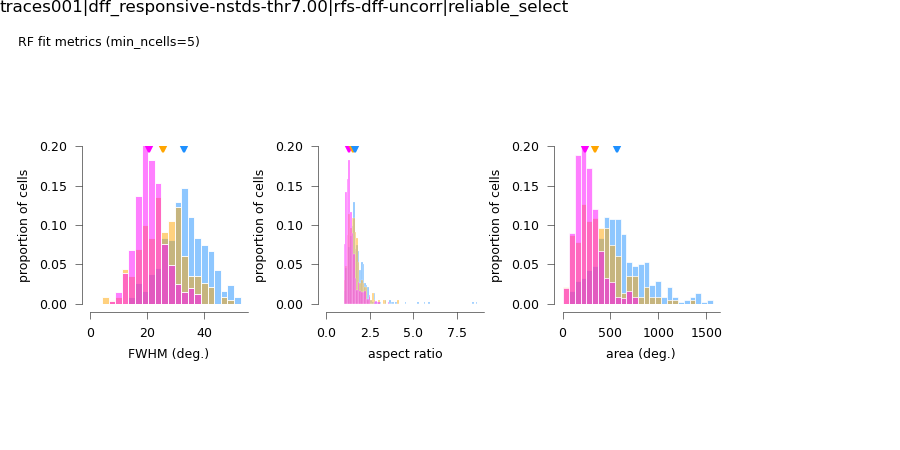

No handles with labels found to put in legend.


/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics hist_per-area_metrics


fwhm_avg                                                        \
               count       mean       std        min        25%        50%   
visual_area                                                                  
Li             373.0  33.239836  7.593435  14.186013  28.325986  33.015422   
Lm             229.0  25.808386  7.976604   4.192896  19.962565  25.441415   
V1             555.0  21.320394  5.373961   7.753588  17.994567  20.780352   

                                  aspect_ratio            ...            \
                   75%        max        count      mean  ...       75%   
visual_area                                               ...             
Li           38.260519  52.820103        373.0  1.817151  ...  1.993582   
Lm           30.859410  48.955025        229.0  1.635796  ...  1.772155   
V1           24.082068  38.785655        555.0  1.427571  ...  1.527364   

                        area                                                 \
                  max  count        mean         std        min         25%   
visual_area                                                                   
Li           8.675383  373.0  608.859000  280.980505  77.529152  427.681067   
Lm           4.119268  229.0  390.161546  232.460762   9.030843  215.083713   
V1           3.568268  555.0  264.338898  133.618842  33.913805  176.212724   

                                                  
                    50%         75%          max  
visual_area                                       
Li           567.515025  762.035086  1565.608267  
Lm           342.975316  516.874781  1347.108976  
V1           235.956799  321.941449   785.081282  

[3 rows x 24 columns]

In [41]:
%matplotlib notebook
means_= finaldf.groupby('visual_area').median()
plot_params = ['fwhm_avg', 'aspect_ratio', 'area']
name_lut = {'fwhm_avg': 'FWHM (deg.)',
            'aspect_ratio': 'aspect ratio',
            'area': 'area (deg.)'}
fig, axn = pl.subplots(1,len(plot_params), figsize=(6,3), dpi=150)

ylim=0.2
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=finaldf, ax=ax,
                 hue='visual_area', hue_order=visual_areas,palette=area_colors, 
                 stat='probability', common_norm=False, edgecolor='w')
    ax.legend_.remove()
    ax.set_xlim([0, ax.get_xlim()[-1]])
    for va, vc in area_colors.items():
        m = float(means_.loc[va, par])
        ax.plot(m, ylim, color=vc, marker='v')
    ax.set_ylim([0, ylim])
    ax.set_box_aspect(1)
    ax.set_xlabel(name_lut[par])
    ax.set_ylabel('proportion of cells')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pplot.adjust_subplots(bottom=0.2, right=0.8, wspace=0.5)
sns.despine(offset=4)
fig.text(0.02, 0.9, 'RF fit metrics (min_ncells=%i)' % min_ncells)

pplot.label_figure(fig, data_id)
figname = 'hist_per-area_metrics'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
finaldf.groupby(['visual_area'])[plot_params].describe()

<IPython.core.display.Javascript object>


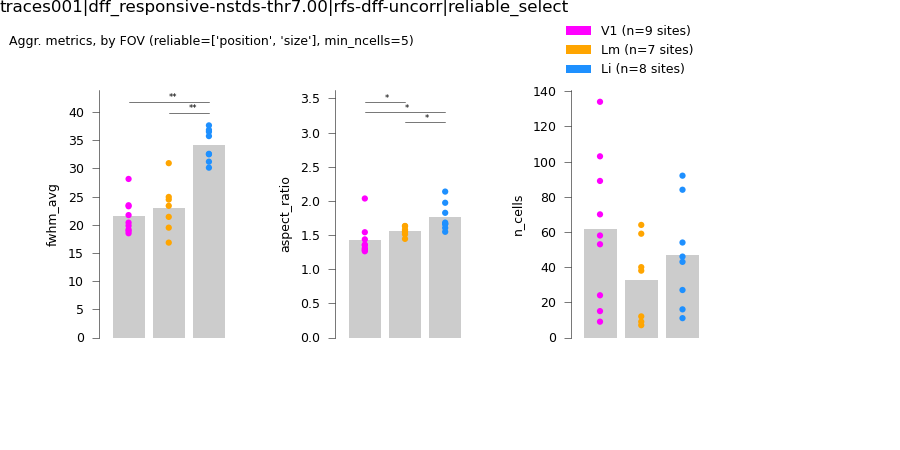

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics per-area_metrics_byFOV
fwhm_avg ----------------------------
             count   mean   std    min    25%    50%    75%    max
visual_area                                                       
Li             8.0  34.12  2.86  30.12  32.16  34.14  36.56  37.61
Lm             7.0  23.05  4.50  16.83  20.44  23.35  24.69  30.92
V1             9.0  21.47  3.09  18.48  19.14  20.37  23.27  28.12
aspect_ratio ----------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             8.0  1.76  0.20  1.55  1.65  1.67  1.86  2.14
Lm             7.0  1.56  0.07  1.44  1.53  1.56  1.61  1.63
V1             9.0  1.43  0.24  1.26  1.29  1.35  1.44  2.03
n_cells ----------------------------
             count   mean    std   min    25%   50%   75%    max
visual_area                                                    

In [42]:
# Plot PER FOV averages
%matplotlib notebook
means_= finaldf.groupby('visual_area').median()

plot_params = ['fwhm_avg', 'aspect_ratio', 'n_cells']
name_lut = {'fwhm_avg': 'FWHM (deg.)',
            'aspect_ratio': 'aspect ratio',
            'n_cells': 'Num. cells with RFs'
           }
fig, axn = pl.subplots(1,len(plot_params), figsize=(6,3),dpi=150)
fov_meds = finaldf.groupby(['visual_area', 'datakey']).median().reset_index()

for ax, par in zip(axn.flat, plot_params):
    y_loc=np.ceil(fov_meds[par].max())
    offset = y_loc/20.
    pplot.stripplot_metric_by_area(fov_meds, ax=ax, metric=par,markersize=3,
                            area_colors=area_colors, posthoc='fdr_bh',
                            y_loc=y_loc+offset, offset=offset, #ylim=(0, 1.03),
                            aspect=2, sig_fontsize=4, jitter=False,
                            return_stats=True, plot_means=True,
                            mean_style='bar', mean_type='mean'   )
    ax.set_xticklabels('')

va_labels = dict((va, '%s (n=%i sites)' % (va, len(g['datakey'].unique()))) \
             for va, g in fov_meds.groupby('visual_area'))
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=[va_labels[v] for v in visual_areas],
                                   linestyles='', use_patch=True)
ax.legend(handles=leg_h, bbox_to_anchor=(1.01,1.01), loc='lower right', 
          frameon=False, markerscale=0.25)
pplot.adjust_subplots(bottom=0.25, right=0.8)
sns.despine(offset=4, bottom=True)
fig.text(0.01, 0.9, 'Aggr. metrics, by FOV (reliable=%s, min_ncells=%i)' \
                 % (str(pass_criterion), min_ncells))

pplot.label_figure(fig, data_id)
figname = 'per-area_metrics_byFOV'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
for par in plot_params:
    print("%s ----------------------------" % par)
    print(fov_meds.groupby(['visual_area'])[par].describe().round(2))
    

In [43]:
projdf = sct.stack_axes(aligned_soma)

projdf['deg_scatter_abs'] = projdf['deg_scatter'].abs()
projdf['dist_scatter_abs'] = projdf['dist_scatter'].abs()

# Eccentricity?

In [32]:
az_min, az_max = (-60, 60)
az_step = 2
az_bins = np.arange(az_min, az_max+az_step, az_step)

el_min, el_max = (-40, 40)
el_step = 2
el_bins = np.arange(az_min, az_max+az_step, az_step)

df = finaldf.copy()
df = cr.cut_bins(df, az_bins, 'x0')
df = cr.cut_bins(df, el_bins, 'y0')

<IPython.core.display.Javascript object>


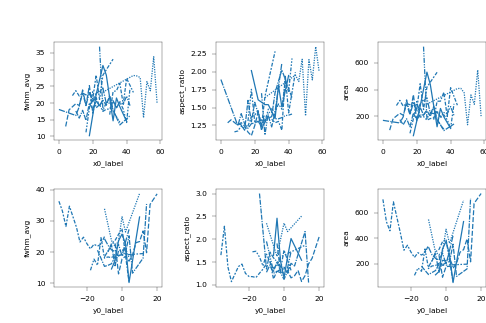

In [36]:
plot_params = ['fwhm_avg', 'aspect_ratio', 'area']

fig, axn = pl.subplots(2, len(plot_params), figsize=(6,4), sharex=False, sharey=False)
for pi, param in enumerate(plot_params):
    for ai, axcond in enumerate(['x0', 'y0']):
        x_var = '%s_label' % axcond
        fov_means = df.groupby(['visual_area', 'datakey', x_var]).median().reset_index()
        plotd = fov_means[(fov_means.visual_area=='V1')]
        ax=axn[ai, pi]
        sns.lineplot(x=x_var, y=param, style='datakey', data=plotd, ax=ax,
                    lw=1)
        ax.legend_.remove()
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, wspace=0.5, hspace=0.5)
# ax=axn[1]
# sns.scatterplot(x='y0', y='fwhm_avg', data=df_, ax=ax)
# ax=axn[0]
# sns.scatterplot(x='x0', y='fwhm_avg', data=df_, ax=ax)
# ax=axn[1]
# sns.scatterplot(x='y0', y='fwhm_avg', data=df_, ax=ax)

In [37]:
axis_colors={'az': 'blue', #[0.7]*3,
             'el': 'orange'} #[0.5]*3}

<IPython.core.display.Javascript object>


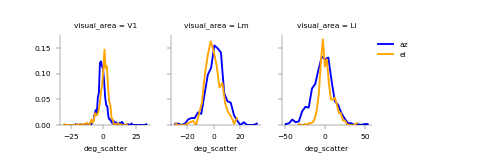

<IPython.core.display.Javascript object>


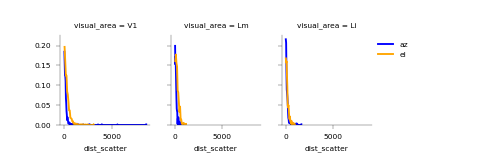

In [45]:
x_var = 'deg_scatter'
%matplotlib notebook
plot_cdf=False
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                   #row='experiment', row_order=['rfs', 'rfs10'],
                  data=projdf, hue='axis', palette=axis_colors, height=2,
                  sharex=False)
fg.map(sns.histplot, x_var, cumulative=plot_cdf, element='poly', fill=False,
      common_norm=False, stat='probability')
for ax in fg.fig.axes:
    ax.set_box_aspect(1)
    
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.8)
x_var = 'dist_scatter'
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=projdf, hue='axis', palette=axis_colors, height=2)
fg.map(sns.histplot, x_var, cumulative=plot_cdf, element='poly', fill=False,
      common_norm=False, stat='probability')
for ax in fg.fig.axes:
    ax.set_box_aspect(1)
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.8)

## Greater scatter with eccentricity?

In [108]:
az_min, az_max = (0, 60)
az_step = 5.
x_bins = np.arange(az_min, az_max+az_step, az_step)

df = projdf.copy()
df = cr.cut_bins(df, x_bins, 'eccentricity')
df = cr.cut_bins(df, x_bins, 'eccentricity_ctr')

<IPython.core.display.Javascript object>


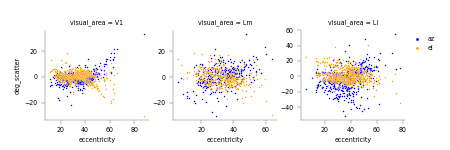

In [109]:

fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=df, hue='axis', palette=axis_colors, height=2,
                  sharex=False, sharey=False)
fg.map(sns.scatterplot, 'eccentricity', 'deg_scatter', s=2)
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
#sns.scatterplot(x='rf_pos', y='deg_scatter', ax=ax, data=projdf)

<IPython.core.display.Javascript object>


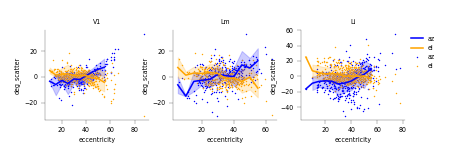

In [112]:
y_var='deg_scatter'
dist_var = 'eccentricity'
scatter_kws = {'size': 2}
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=df, hue='axis', palette=axis_colors, height=2,
                  sharex=False, sharey=False)
fg.map(sns.scatterplot, dist_var, y_var, s=2)
fg.set_titles('{col_name}')
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var='%s_label' % dist_var
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var]).mean().reset_index()
for ai, ax in enumerate(fg.fig.axes):
    plotd = binned_df[binned_df.visual_area==ax.title.get_text()].copy()
    sns.lineplot(x=x_var, y=y_var, hue='axis', data=plotd, ax=ax,
                palette=axis_colors, ci='sd')
    if ai==2:
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    else:
        ax.legend_.remove()
#     sns.lineplot(x=x_var, y=y_var, data=plotd, ax=ax,
#                  color='k',  ci='sd')

<IPython.core.display.Javascript object>


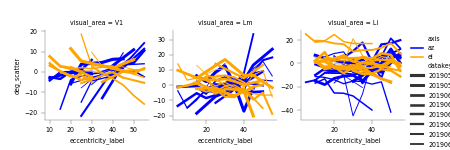

In [113]:
x_var='eccentricity_label'
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var])\
              .mean().reset_index()
plotd = binned_df.copy()
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=plotd, height=2,
                  sharex=False, sharey=False)
fg.map(sns.lineplot, x_var, 'deg_scatter', 'axis', 'datakey',
       hue='axis', palette=axis_colors) #, scatter_kws=scatter_kws)
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

## RF size ("CMF" for single-cell) vs. eccentricity?

<IPython.core.display.Javascript object>


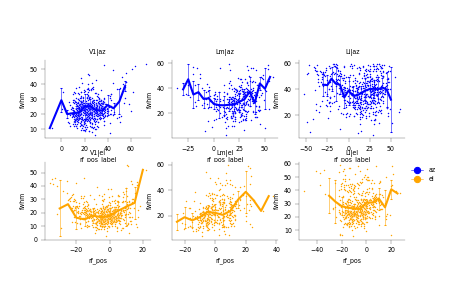

In [114]:
scatter_kws = {'s': 2}
y_var = 'fwhm' # 'vectorproj'
dist_var='rf_pos'
az_min, az_max = (-30, 60)
az_step = 5.
x_bins = np.arange(az_min, az_max+az_step, az_step)
df = projdf.copy()
df = cr.cut_bins(df, x_bins, dist_var)
# -----------------------------------------------------------------
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas,data=df, 
                   row='axis',
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.scatterplot, dist_var, y_var, s=2)
fg.set_titles('{col_name}|{row_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
x_var='%s_label' % dist_var
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var]).mean().reset_index()
for ai, ax in enumerate(fg.fig.axes):
    va, cnd = ax.title.get_text().split('|')
    plotd = binned_df[(binned_df.visual_area==va) & (binned_df.axis==cnd)].copy()
    sns.lineplot(x=x_var, y=y_var, data=plotd, ax=ax,
                 hue='axis', palette=axis_colors, 
                 ci='sd', err_style='bars',
                 lw=2, err_kws={'elinewidth':0.5, 'capsize':0.5})
    ax.legend_.remove()
leg_h = pplot.custom_legend_markers(colors=[axis_colors[c] for c in ['az', 'el']],
                                   labels=['az', 'el'])
fg.axes.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
                        frameon=False, markerscale=1)

<IPython.core.display.Javascript object>


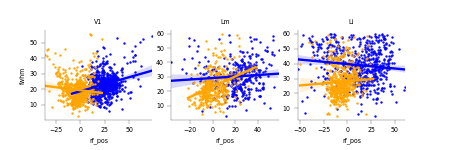

<IPython.core.display.Javascript object>


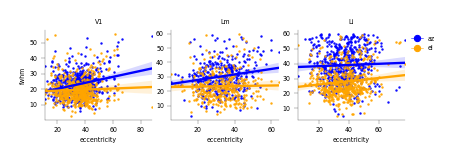

In [115]:
scatter_kws = {'s': 2}
y_var = 'fwhm' # 'vectorproj'
x_var='rf_pos'
# -----------------------------------------------------------------
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas,data=df, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var,scatter_kws=scatter_kws)# s=2)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var='eccentricity'
# -----------------------------------------------------------------
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas,data=df, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var,scatter_kws=scatter_kws)# s=2)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

leg_h = pplot.custom_legend_markers(colors=[axis_colors[c] for c in ['az', 'el']],
                                   labels=['az', 'el'])
fg.axes.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
                        frameon=False, markerscale=1)

<IPython.core.display.Javascript object>


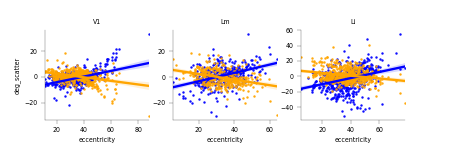

<IPython.core.display.Javascript object>


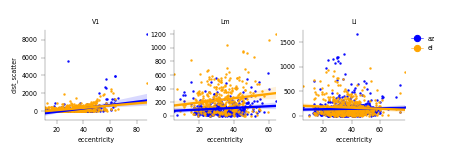

In [116]:
x_var = 'eccentricity'
y_var = 'deg_scatter'
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=projdf, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var, scatter_kws=scatter_kws)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var = 'eccentricity'
y_var = 'dist_scatter'
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=projdf, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var, scatter_kws=scatter_kws)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

#legend
leg_h = pplot.custom_legend_markers(colors=[axis_colors[c] for c in ['az', 'el']],
                                   labels=['az', 'el'])
fg.axes.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
                        frameon=False, markerscale=1)

In [117]:
projdf['deg_scatter_abs'] = projdf['deg_scatter'].abs()

In [118]:
cnts_fov = pd.concat([pd.DataFrame({'visual_area': va,
               'datakey': dk, 
               'n_cells': len(g['cell'].unique())}, index=[i])\
              for i, ((va, dk), g) in enumerate(df.groupby(['visual_area', 'datakey']))])

for (va, dk), g in df.groupby(['visual_area', 'datakey']):
    df.loc[g.index, 'n_cells'] = len(g['cell'].unique()) #len(df[() & ()]['cell'].unique())
    
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var]).mean().reset_index()

<IPython.core.display.Javascript object>


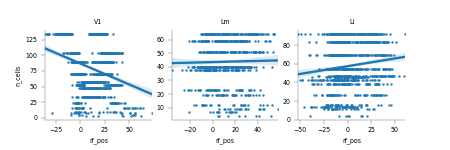

No handles with labels found to put in legend.


In [120]:
y_var = 'n_cells'
x_var =  dist_var # '%s_label' % dist_var
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=binned_df, palette=axis_colors, height=2,
                  sharex=False, sharey=False)
fg.map(sns.regplot, dist_var, y_var, scatter_kws=scatter_kws)
fg.set_titles('{col_name}')
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)


# Aggregate RF comparisons

In [31]:
from functools import reduce

In [30]:
va='V1'
dk='20190617_JC097_fov1'
df_ = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
# Calculate PW diffs of RF metrics
diffs = cr.get_pw_rf_diffs(df_)
# Calculate overlaps (pw)
rois_ = df_['cell'].unique()
curr_polys = rfpolys[(rfpolys.datakey==dk) & (rfpolys['cell'].isin(rois_))]
print(dk, curr_polys.shape)
if len(curr_polys)<=1:
    print("NONE, skipping overlaps")  
overlaps_ = rfutils.get_rf_overlaps(curr_polys)
overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) for c1, c2 \
                                in overlaps_[['cell_1', 'cell_2']].values] 

20190617_JC097_fov1 (77, 3)


In [32]:
# combine
dfs_to_merge=[diffs, overlaps_]
pw_df = reduce(lambda  left,right: pd.merge(left,right,\
                                    on=['neuron_pair', 'cell_1', 'cell_2'],
                                    how='outer'), dfs_to_merge)

<IPython.core.display.Javascript object>


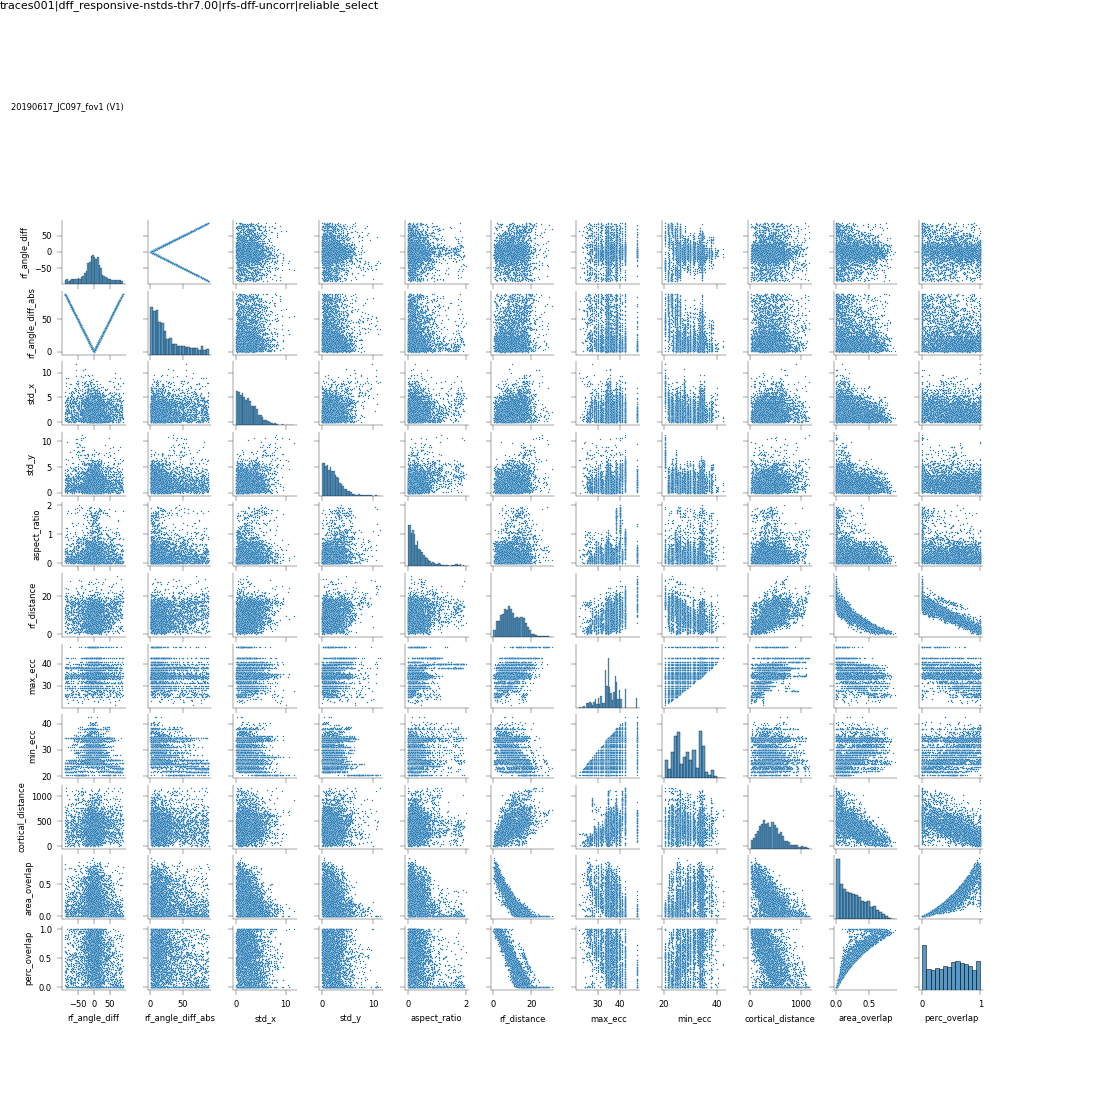

In [33]:
rf_diff_params = [c for c in pw_df.columns \
                  if c not in ['neuron_pair', 'cell_1', 'cell_2']]
fg = sns.pairplot(pw_df, vars=rf_diff_params, height=1, plot_kws={'s':1})
pl.subplots_adjust(left=0.05, right=0.9, bottom=0.1, top=0.8)
for ax in fg.fig.axes:
    ax.set_box_aspect(1)
fg.fig.text(0.01, 0.9, '%s (%s)' % (dk, va))

pplot.label_figure(fg.fig, data_id)
pl.savefig(os.path.join(examples_dir, 'pairplot_rf_metrics.svg'))


# AGG

In [34]:
DISTS = cr.aggregate_ccdist(NDATA, experiment='rfs', rfdf=rfdf, rfpolys=rfpolys)

Dist: rf_distance
Li 20190527_JC092_fov3 rfs10
    getting rf metrics
Li 20190528_JC092_fov1 rfs10
    getting rf metrics
Li 20190602_JC091_fov1 rfs10
    getting rf metrics
Li 20190612_JC099_fov1 rfs10
    getting rf metrics
Li 20190614_JC091_fov1 rfs10
    getting rf metrics
Li 20190617_JC099_fov1 rfs10
    getting rf metrics
Li 20191017_JC113_fov1 rfs10
    getting rf metrics
Li 20191106_JC120_fov1 rfs10
    getting rf metrics
Lm 20190430_JC078_fov1 rfs
    getting rf metrics
Lm 20190504_JC078_fov1 rfs
    getting rf metrics
Lm 20190508_JC083_fov1 rfs
    getting rf metrics
Lm 20190525_JC084_fov1 rfs
    getting rf metrics
Lm 20190603_JC080_fov1 rfs
    getting rf metrics
Lm 20190618_JC097_fov1 rfs
    getting rf metrics
Lm 20190627_JC091_fov1 rfs
    getting rf metrics
V1 20190501_JC076_fov1 rfs
    getting rf metrics
V1 20190507_JC083_fov1 rfs
    getting rf metrics
V1 20190508_JC083_fov1 rfs
    getting rf metrics
V1 20190522_JC084_fov1 rfs
    getting rf metrics
V1 20190613_JC09

In [48]:
DISTS.shape, DISTS.dropna().shape

((168665, 21), (22929, 21))

In [51]:
# DISTS['area_overlap'] = DISTS['area_overlap'].astype(float)
# DISTS['perc_overlap'] = DISTS['perc_overlap'].astype(float)
DISTS.groupby('visual_area').count()

cell_1  cell_2  signal_cc  neuron_pair  noise_cc  rf_distance  \
visual_area                                                                  
Li            16586   16586      16586        16586     16586         3006   
Lm            66881   66881      66881        66881     66881         3555   
V1            85198   85198      85198        85198     85198        16393   

             max_ecc  min_ecc  cortical_distance  area_overlap  perc_overlap  \
visual_area                                                                    
Li              3006     3006              16586          5104          5104   
Lm              3555     3555              66881          4150          4150   
V1             16393    16393              85198         23883         23883   

             rf_angle_diff  rf_angle_diff_abs  std_x  std_y  aspect_ratio  \
visual_area                                                                 
Li                    2981               2981   2981   2981          2981   
Lm                    3555               3555   3555   3555          3555   
V1                   16393              16393  16393  16393         16393   

             overlap_index  datakey  experiment  n_cells  
visual_area                                               
Li                    5104    16586       16586    16586  
Lm                    4150    66881       66881    66881  
V1                   23883    85198       85198    85198

## Heatmap: signal_cc vs. both RF & CX distance

In [87]:
# Split distances into X um bins
ctx_maxdist = 500 #500
rf_maxdist=np.inf
df, dist_lut = cr.get_bins_and_cut(DISTS[(DISTS.cortical_distance<=ctx_maxdist)
                                        & (DISTS.rf_distance<=rf_maxdist)], 
                                   ctx_step=25, rf_step=2, overlap_step=0.1)

In [88]:
x_var = 'cortical_distance'
y_var = 'rf_distance'
hue_var = 'signal_cc'
# -----------------------------
min_npairs=5
x_bins = dist_lut[x_var]['bins']
y_bins = dist_lut[y_var]['bins']

x_var_name = '%s_label' % x_var
y_var_name = '%s_label' % y_var

hue_min = df.groupby(['visual_area', x_var_name, y_var_name])[hue_var].mean().min()
hue_max = df.groupby(['visual_area', x_var_name, y_var_name])[hue_var].mean().max()
print(hue_min, hue_max)

-0.5914348158965432 0.8239653145167253


<IPython.core.display.Javascript object>


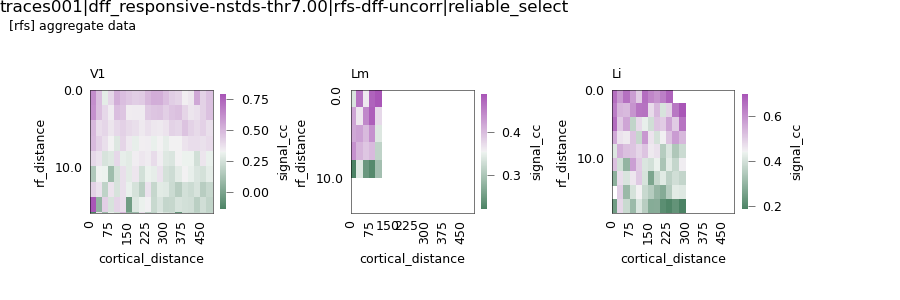

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics heatmaps_aggrFOV_rf_distance_v_cortical_distance_hue-signal_cc


In [89]:
cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
hue_min, hue_max = None, None #@(-1, 1)
#hue_min, hue_max =  (-0.8, 0.8)
min_npairs=20
fig, axn = pl.subplots(1, 3, figsize=(6, 2), dpi=150, sharex=True, sharey=False)
#cbar_ax = fig.add_axes([0.8, 0.3, 0.01, 0.3])
for ai, (va, vg) in enumerate(df.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    cnts = vg.groupby([x_var_name, y_var_name])['neuron_pair'].count().reset_index()
    valid_x = cnts[cnts['neuron_pair']>=min_npairs][x_var_name].unique()
    valid_y = cnts[cnts['neuron_pair']>=min_npairs][y_var_name].unique()
    df0 = vg[(vg[x_var_name].isin(valid_x)) & (vg[y_var_name].isin(valid_y))]

    ax=cr.heatmap_tuning_v_distance(df0, x_bins, y_bins, ax=ax,
                                      x_var=x_var, y_var=y_var, 
                                      hue_var=hue_var, hue_norm=(hue_min, hue_max),
                                     cmap=cmap, cbar=True)
#                                       cmap=cmap, cbar=ai==0, 
#                                       cbar_ax=cbar_ax if ai==0 else None)
    ax.set_title(va, loc='left', fontsize=6)
    yticks = np.arange(0, len(y_bins))
    curr_ylim = df0.dropna()[y_var_name].max()
    ax.set_ylim([0, list(y_bins).index(curr_ylim)])
    ax.set_yticklabels([round(y_bins[i], 1) if i in yticks[0::5] else ''\
                       for i in yticks])
    ax.set_ylabel(y_var)
    ax.set_xlabel(x_var)
    ax.invert_yaxis()
    ax.set_box_aspect(1)
fig.text(0.01, 0.9, '[%s] aggregate data' % experiment)
pl.subplots_adjust(wspace=0.7, right=0.85, left=0.1)

pplot.label_figure(fig, data_id)
figname = 'heatmaps_aggrFOV_%s_v_%s_hue-%s' % (y_var, x_var, hue_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [89]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

## Binned distance vs. metric (w shuffle)

In [108]:
dist_var = 'rf_distance'
y_var='signal_cc'
cmap='viridis'
# -----------------------------------------------------------
ctx_maxdist=800
ctx_step=25
rf_step=2.0
df, dist_lut = cr.get_bins_and_cut(DISTS[DISTS.cortical_distance<=ctx_maxdist], 
                            ctx_step=ctx_step, rf_step=rf_step, equal_bins=False)
hue_label = '%s_label' % dist_var
x_var = '%s_label' % dist_var

In [109]:
curr_maxdist = dist_lut[dist_var]['max_dist']
bcorrs=df.copy().reset_index(drop=True).dropna()
# shuffle
n_iters=100
shuffle_label = '%s_label' % dist_var #'binned_cortical_distance_label'
dist_bins = dist_lut[dist_var]['bins']
curr_dist_bins=[k for k in dist_bins if k<=curr_maxdist]
mean_cols = ['visual_area',  shuffle_label]
bcorrs_shuff = bcorrs.copy()
shuff_list=[]
for i in np.arange(0, n_iters):
    # Make copy
    vg_shuff = bcorrs_shuff.copy()
    # Shuffle by area
    vg_shuff[shuffle_label] = bcorrs_shuff.groupby(['visual_area'])[shuffle_label]\
                                .transform(np.random.permutation)
    # Get mean 
    mean_ = vg_shuff.groupby(mean_cols).mean().reset_index()
    shuff_list.append(mean_)
shuff_ = pd.concat(shuff_list, axis=0, ignore_index=True)

shuff_['condition'] = 'shuffled'
bcorrs['condition'] = 'data'
combined_ = pd.concat([bcorrs, shuff_], axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


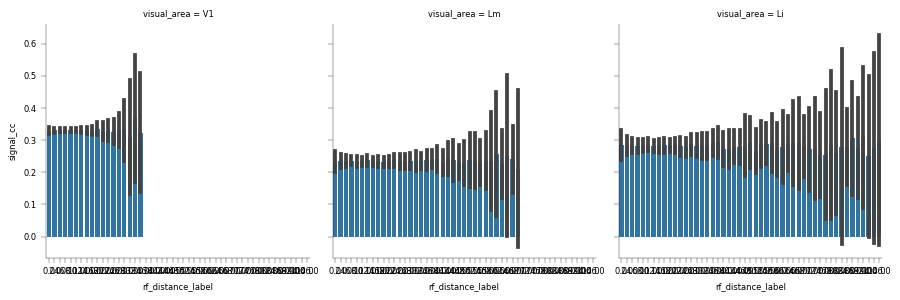

In [110]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=shuff_)
fg.map(sns.barplot, shuffle_label, 'signal_cc' , ci='sd')

In [114]:
x_bins = sorted(curr_dist_bins.copy())
x_bins[5]

10.0

<IPython.core.display.Javascript object>


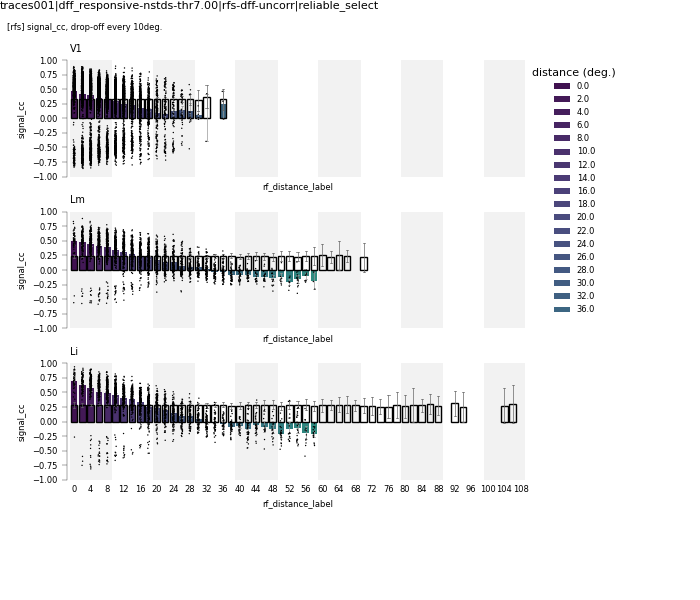

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics binned-dist-bar_signal_cc_v_rf_distance_max60_wpairs


In [117]:
%matplotlib notebook
bin_width=5 # 4 if ctx=25um
plot_pairs = True
curr_maxdist=60

x_bins = sorted(curr_dist_bins.copy())
xticks = np.arange(0, len(x_bins))
patch_step = x_bins[bin_width] #+dist_lut[dist_var]['step']
if dist_var in ['cortical_distance', 'rf_distance']:
    xlabels = [int(i) if i in x_bins[0::2] else ''\
                        for i in x_bins]
else:
    xlabels = [float(i) if i in x_bins[0::2] else ''\
                        for i in x_bins]
dist_cols = sns.color_palette(cmap, n_colors=len(x_bins))
dist_cdict = dict((k, v) for k, v in zip(x_bins, dist_cols))
#
plotd = combined_[combined_[dist_var]<=curr_maxdist].copy()
dist_unit = 'um' if dist_var=='cortical_distance' else 'deg.'
plot_str = '_wpairs' if plot_pairs else ''

ymax=1
fig, axn = pl.subplots(3, 1, figsize=(7,6),sharex=True, sharey=True)
for va, vg0 in plotd.groupby('visual_area'):
    vg = vg0[vg0['condition']=='data']
    ax=axn[visual_areas.index(va)]
    # Set ticks
    if va =='V1' or va=='Lm':
        ax.set_xlabel('')
    else:
        ax.set_xlabel('%s bin (%s)' % (dist_var, dist_unit))
    ax.set_ylim([-ymax, ymax])
    # background patch?
    ymin = ax.get_ylim()[0]
    yh = ax.get_ylim()[-1] - ymin
    rect_list=[]
    for bi, bv in enumerate(x_bins):
        if bi%int(bin_width*2)==0:
            rect = mpl.patches.Rectangle((bi-0.5, ymin), 
                                         bin_width, yh, fc=[0.95]*3)
        rect_list.append(rect)
    rect_coll=mpl.collections.PatchCollection(rect_list, zorder=-100,
                                             match_original=True)
    ax.add_collection(rect_coll)
    # bars
    sns.barplot(x=x_var, y=y_var, data=vg, ax=ax,
               order=x_bins, errcolor=[0.6]*3,
               hue=hue_label, dodge=False, ci=95, errwidth=0.5,
               palette=dist_cdict, zorder=1,alpha=1, capsize=0.25)
    if va=='V1':
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False, 
              title='distance (%s)' % dist_unit)
    else:
        ax.legend_.remove()
    # Shuffled mean
    vg_shuff = vg0[vg0.condition=='shuffled']
    sns.barplot(x=x_var, y=y_var, data=vg_shuff, ax=ax, errcolor=[0.4]*3,
                order=x_bins, dodge=False, ci='sd', errwidth=0.5, lw=1,
                zorder=1, facecolor=(1,1,1,0), edgecolor=['k']*4,capsize=0.25)
    # individual neuron pairs
    if plot_pairs:
        sns.stripplot(x=x_var, y=y_var, ax=ax, data=vg, color='k', #palette=grp_colors,
               order=x_bins, dodge=False, size=1)
    
    ax.set_title(va, loc='left', fontsize=7)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xticklabels(xlabels)
sns.despine(bottom=True, trim=True, offset=2)
pl.subplots_adjust(left=0.1, right=0.75, bottom=0.2, top=0.9, hspace=0.3)
fig.text(0.01, 0.95, "[%s] %s, drop-off every %i%s" \
         % (experiment, y_var, patch_step, dist_unit))

pplot.label_figure(fig, data_id)
figname = 'binned-dist-bar_%s_v_%s_max%i%s' % (y_var, dist_var, curr_maxdist, plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

#### double-check anti-corrs


<IPython.core.display.Javascript object>


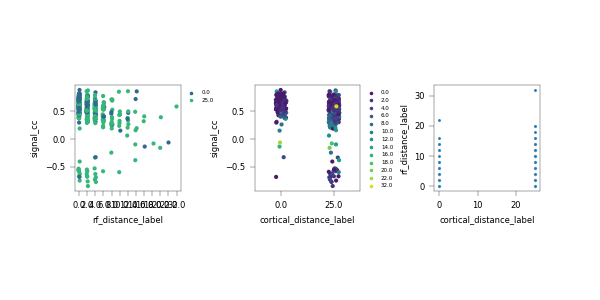

In [325]:
y_var='signal_cc'
va='V1'
vg = plotd[(plotd['visual_area']==va) & (plotd.cortical_distance_label<50)].copy()

fig, axn = pl.subplots(1,3, figsize=(6,3))
ax=axn[0]
dist_var='rf_distance'
x_var = '%s_label' % dist_var
sns.stripplot(x=x_var, y=y_var, data=vg, ax=ax, s=3,
              hue='cortical_distance_label', palette='viridis')
ax.legend(bbox_to_anchor=(1,1), loc='upper left',frameon=False, 
          fontsize=4, markerscale=0.2)

ax=axn[1]
dist_var='cortical_distance'
x_var = '%s_label' % dist_var
sns.stripplot(x=x_var, y=y_var, data=vg, ax=ax, s=3, 
              hue='rf_distance_label', palette='viridis')
ax.legend(bbox_to_anchor=(1,1), loc='upper left',frameon=False, 
          fontsize=4, markerscale=0.2)
ax=axn[2]
sns.scatterplot(x='cortical_distance_label', 
                y='rf_distance_label', data=vg, ax=ax, s=5)
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.2, right=0.9, wspace=0.7)


In [326]:
va='V1'
df['visual_area'] = df['visual_area'].astype(str)
vg = df[(df['visual_area']==va) & (df.cortical_distance_label<100)].copy()

<IPython.core.display.Javascript object>


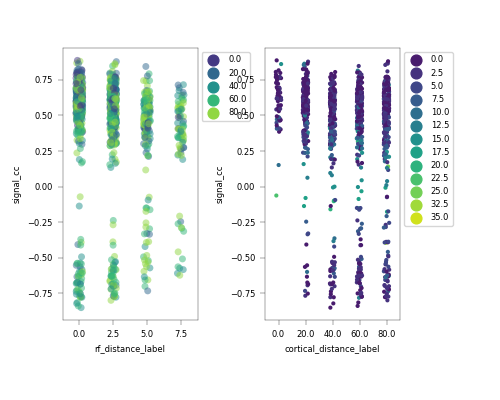

In [327]:
fig, axn = pl.subplots(1,2)
df_ = vg[(vg.rf_distance_label<10)]

ax=axn[0]
dist_var='rf_distance'
x_var = '%s_label' % dist_var
sns.stripplot(x=x_var, y=y_var, data=df_, ax=ax, s=5, alpha=0.5,
              hue='cortical_distance_label', palette='viridis')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

ax=axn[1]
dist_var='cortical_distance'
x_var = '%s_label' % dist_var
sns.stripplot(x=x_var, y=y_var, data=vg, ax=ax, s=3, 
              hue='rf_distance_label', palette='viridis')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

pl.subplots_adjust(bottom=0.2, right=0.8, wspace=0.5)


In [328]:
neg_cc = df_[df_['signal_cc']<-0.5].copy() 
neg_cc.groupby(['visual_area', 'datakey']).count()

cell_1  cell_2  signal_cc  neuron_pair  \
visual_area datakey                                                       
V1          20190508_JC083_fov1       8       8          8            8   
            20190522_JC084_fov1      80      80         80           80   
            20190613_JC097_fov1       1       1          1            1   
            20190616_JC097_fov1      12      12         12           12   

                                 noise_cc  rf_distance  max_ecc  min_ecc  \
visual_area datakey                                                        
V1          20190508_JC083_fov1         8            8        8        8   
            20190522_JC084_fov1        80           80       80       80   
            20190613_JC097_fov1         1            1        1        1   
            20190616_JC097_fov1        12           12       12       12   

                                 cortical_distance  area_overlap  ...  \
visual_area datakey                                               ...   
V1          20190508_JC083_fov1                  8             8  ...   
            20190522_JC084_fov1                 80            80  ...   
            20190613_JC097_fov1                  1             1  ...   
            20190616_JC097_fov1                 12            12  ...   

                                 area_overlap_label  area_overlap_value  \
visual_area datakey                                                       
V1          20190508_JC083_fov1                   8                   8   
            20190522_JC084_fov1                  80                  80   
            20190613_JC097_fov1                   1                   1   
            20190616_JC097_fov1                  12                  12   

                                 binned_signal_cc  signal_cc_label  \
visual_area datakey                                                  
V1          20190508_JC083_fov1                 8                8   
            20190522_JC084_fov1                80               80   
            20190613_JC097_fov1                 1                1   
            20190616_JC097_fov1                12               12   

                                 signal_cc_value  binned_noise_cc  \
visual_area datakey                                                 
V1          20190508_JC083_fov1                8                8   
            20190522_JC084_fov1               80               80   
            20190613_JC097_fov1                1                1   
            20190616_JC097_fov1               12               12   

                                 noise_cc_label  noise_cc_value  \
visual_area datakey                                               
V1          20190508_JC083_fov1               8               8   
            20190522_JC084_fov1              80              80   
            20190613_JC097_fov1               1               1   
            20190616_JC097_fov1              12              12   

                                 signal_cc_abs  site_num  
visual_area datakey                                       
V1          20190508_JC083_fov1              8         8  
            20190522_JC084_fov1             80        80  
            20190613_JC097_fov1              1         1  
            20190616_JC097_fov1             12        12  

[4 rows x 39 columns]

In [352]:
dk = '20190616_JC097_fov1'
checkdf= neg_cc[(neg_cc.datakey==dk)].copy()

rois_ = np.union1d(checkdf['cell_1'], checkdf['cell_2'])
rois_

array([149, 151, 152, 153, 156, 157, 160, 164, 165, 170, 171, 172, 174])

In [353]:
rfname = 'rfs'
rfit_df = rfutils.load_rf_fits(dk, experiment=rfname, fit_desc=rf_fit_desc) 
print(rfit_df.shape)

(103, 27)


In [354]:
eval_results, eval_params = rfutils.load_eval_results(dk,
                                       experiment=rfname, fit_desc=rf_fit_desc)
reliable_rois = rfutils.get_reliable_fits(eval_results['pass_cis'],
                                        pass_criterion='position')
curr_rois = np.intersect1d(rois_, reliable_rois)


In [355]:
curr_rois

array([149, 151, 152, 153, 156, 157, 160, 164, 165, 170, 171, 172, 174])

In [356]:
curr_fits = rfit_df.loc[curr_rois].copy()
curr_fits.shape
curr_fits['cell'] = curr_fits.index.tolist()

In [357]:
rfs = curr_fits.rename(columns={'std_x': 'sigma_x', 'std_y':'sigma_y'})
screen = hutils.get_screen_dims()
sdf_rf = aggr.get_stimuli(dk, 'rfs')

In [358]:
checkdf.sort_values(by='signal_cc', ascending=True)

cell_1  cell_2  signal_cc neuron_pair  noise_cc  rf_distance  \
125771     165     174  -0.711675     165_174 -0.202614     1.944258   
126092     172     174  -0.624952     172_174 -0.202807     2.609769   
124871     153     174  -0.624504     153_174 -0.169638     2.944555   
125986     171     174  -0.608199     171_174 -0.214315     1.123669   
124754     152     174  -0.597327     152_174 -0.098135     0.864332   
125216     157     174  -0.566020     157_174 -0.144639     2.534120   
125323     160     164  -0.552520     160_164 -0.057064     1.111068   
125879     170     174  -0.541312     170_174 -0.176786     2.108640   
125096     156     164  -0.531022     156_164 -0.080732     4.436422   
124636     151     174  -0.527171     151_174 -0.122431     2.587178   
124517     149     174  -0.515226     149_174 -0.186021     5.231842   
125102     156     174  -0.513481     156_174 -0.128082     4.386166   

          max_ecc    min_ecc  cortical_distance  area_overlap  ...  \
125771  39.346509  37.402572          62.337909      0.804355  ...   
126092  39.346509  36.745651          77.786003      0.774138  ...   
124871  39.346509  37.368500          68.025867      0.645761  ...   
125986  39.346509  38.942376          60.592554      0.694016  ...   
124754  40.092413  39.346509          82.474265      0.612119  ...   
125216  41.379219  39.346509          79.323230      0.650005  ...   
125323  41.145207  40.232895          34.567515      0.406267  ...   
125879  39.346509  37.245643          64.564989      0.775150  ...   
125096  43.594146  40.232895          43.569001      0.619575  ...   
124636  39.346509  36.895587          54.385592      0.636371  ...   
124517  42.136027  39.346509          88.959841      0.476341  ...   
125102  43.594146  39.346509          70.124532      0.640306  ...   

        area_overlap_label  area_overlap_value  binned_signal_cc  \
125771                0.80            0.825888              -0.8   
126092                0.75            0.773963              -0.7   
124871                0.60            0.623264              -0.7   
125986                0.65            0.674078              -0.7   
124754                0.60            0.623264              -0.6   
125216                0.65            0.674078              -0.6   
125323                0.40            0.424711              -0.6   
125879                0.75            0.773963              -0.6   
125096                0.60            0.623264              -0.6   
124636                0.60            0.623264              -0.6   
124517                0.45            0.473996              -0.6   
125102                0.60            0.623264              -0.6   

        signal_cc_label  signal_cc_value  binned_noise_cc  noise_cc_label  \
125771             -0.8        -0.735868             -0.3            -0.3   
126092             -0.7        -0.647513             -0.3            -0.3   
124871             -0.7        -0.647513             -0.2            -0.2   
125986             -0.7        -0.647513             -0.3            -0.3   
124754             -0.6        -0.553159             -0.1            -0.1   
125216             -0.6        -0.553159             -0.2            -0.2   
125323             -0.6        -0.553159             -0.1            -0.1   
125879             -0.6        -0.553159             -0.2            -0.2   
125096             -0.6        -0.553159             -0.1            -0.1   
124636             -0.6        -0.553159             -0.2            -0.2   
124517             -0.6        -0.553159             -0.2            -0.2   
125102             -0.6        -0.553159             -0.2            -0.2   

       noise_cc_value signal_cc_abs site_num  
125771      -0.231761      0.711675      5.0  
126092      -0.231761      0.624952      5.0  
124871      -0.141592      0.624504      5.0  
125986      -0.231761      0.608199      5.0  
124754      -0.025105      0.597327   

<IPython.core.display.Javascript object>


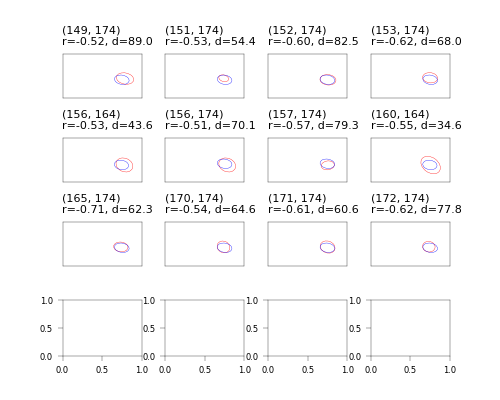

In [363]:
fig, axn = pl.subplots(4,4, figsize=(5,4), dpi=100)
for ax, (npair, g) in zip(axn.flat, checkdf.groupby('neuron_pair')):
    r1, r2 = npair.split('_')
    rlist = sorted([int(i) for i in npair.split('_')])
    r1, r2 = rlist
    cc = float(g['signal_cc'])
    cx_dist = float(g['cortical_distance'])
    ax = rfutils.plot_rfs_to_screen_pretty(rfs, sdf_rf, screen, 
                               ax=ax, fit_roi_list=rlist,
                               roi_colors=['r', 'b'],
                               ellipse_lw=0.25, stimulated_lc='none')
    ax.set_title('(%i, %i)\nr=%.2f, d=%.1f' %(r1, r2, cc, cx_dist), loc='left')
pl.subplots_adjust(wspace=0.3, hspace=0.5)


In [370]:
rfs['visual_area'] = va
rfs['datakey'] = dk
rfs['experiment'] = 'rfs'
print(va, dk)
rfs_pos = aggr.add_roi_positions(rfs)

V1 20190616_JC097_fov1


<IPython.core.display.Javascript object>


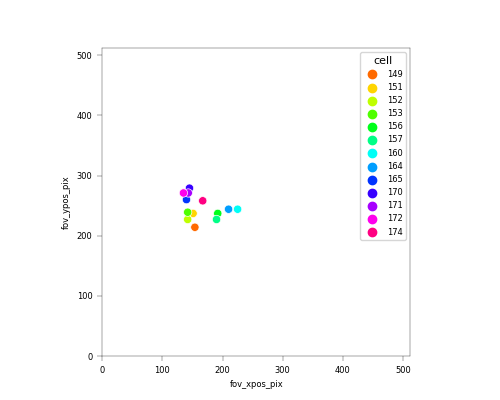

In [372]:
plot_posdf = rfs_pos.loc[curr_rois].copy()
neg_cc_roi_colors = dict((k, v) for k, v in zip(curr_rois, 
                                sns.color_palette('hsv', n_colors=len(curr_rois)))) 

fig, ax = pl.subplots()
sns.scatterplot(x='fov_xpos_pix', y='fov_ypos_pix', data=plot_posdf, ax=ax,
                hue='cell', 
            palette=neg_cc_roi_colors)
ax.set_xlim([0, 512])
ax.set_ylim([0, 512])
ax.set_aspect('equal')

In [361]:
rfs.loc[curr_rois][['fov_xpos', 'fov_ypos']]

fov_xpos    fov_ypos
149  354.893151  407.395695
151  347.979648  451.181213
152  327.239139  432.144031
153  327.239139  454.988650
156  442.464188  451.181213
157  437.855186  432.144031
160  518.512720  464.507241
164  483.945205  464.507241
165  322.630137  494.966732
170  334.152642  531.137378
171  329.543640  515.907632
172  311.107632  515.907632
174  384.851663  491.159295

In [259]:
checkdf['cell_1'].unique()

array([149, 151, 152, 153, 156, 157, 160, 165, 170, 171, 172])

In [261]:
checkdf['cell_2'].unique()

array([174, 164])

In [139]:
DISTS.shape, DISTS.dropna().shape

((168665, 21), (22929, 21))

## Binned distance decay plots

In [49]:
# DISTS['overlap_index'] = 1 - DISTS['area_overlap']

In [308]:
equal_bins=False
n_bins=10

ctx_maxdist=1200
ctx_step=20
rf_step=2.5
df, dist_lut = cr.get_bins_and_cut(DISTS[DISTS.cortical_distance<=ctx_maxdist].dropna(),
                                   ctx_step=ctx_step, rf_step=rf_step,
                                   equal_bins=False,  overlap_step=0.1)

In [309]:
df['signal_cc_abs'] = df['signal_cc'].abs()

<IPython.core.display.Javascript object>


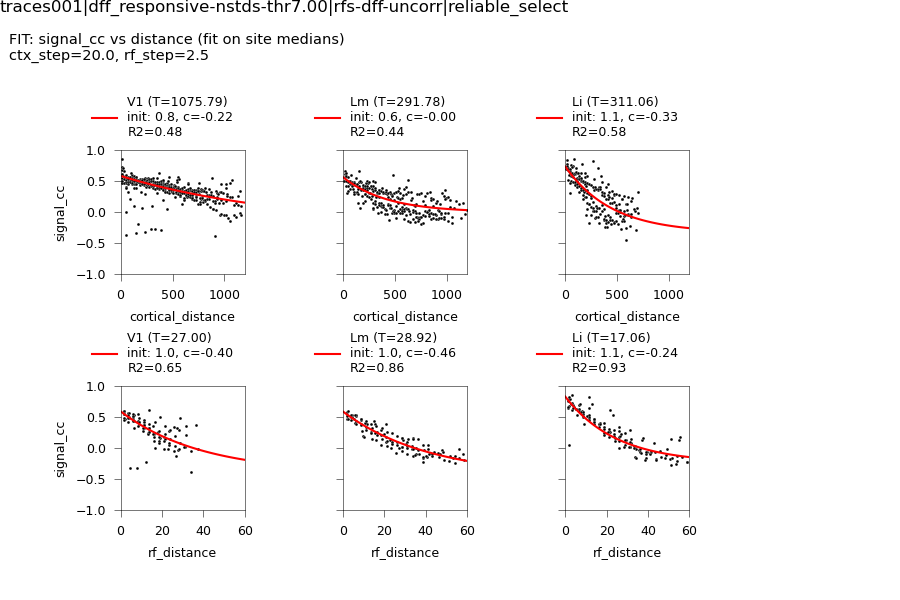

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics decay-fit_signal_cc_dist-metrics_avgfov


In [312]:
%matplotlib notebook
metric='signal_cc'
ylim = (-1, 1)
dist_vars=['cortical_distance', 'rf_distance']
fit_sites = True
use_binned=False
min_npairs = 10
# ---------------------------------------------
fit_str = 'avgfov' if fit_sites else 'cellpairs' 
n_iter=int(np.random.rand(1)[0]*500)
   
fig, axn = pl.subplots(2,3, figsize=(6,4), dpi=150, sharex=False, sharey=True)
for va, vg in df.groupby('visual_area'):
    for ai, dist_var in enumerate(dist_vars):
        ax=axn[ai, visual_areas.index(va)]
        x_var = '%s_label' % dist_var
        curr_maxdist = dist_lut[dist_var]['max_dist']
        cnt_groups = [x_var, 'datakey'] if fit_sites else [x_var]
        nsamples_per = cr.count_nsamples_per_bin(vg, cnt_groups, 
                                                 min_npairs=min_npairs)
        if len(nsamples_per)==0:
            print("    no samples, %s, %s" % (va))
        res_, xvals, yvals = cr.sample_bins_and_fit(vg, nsamples_per, cnt_groups, 
                                        to_quartile=dist_var, metric=metric, 
                                        use_binned=use_binned, normalize_x=True, 
                                        func='halflife', estimator='median',
                                        resample=True)
        if all(res_.isnull()):
            print("BINNED, no fit: %s" % va)
            label='no fit'
        else:
            xvals = np.linspace(0, curr_maxdist, 100)
            fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
            label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                            % (va, res_.tau, res_.init, res_.constant, res_.R2)
            ax.plot(xvals, fit_y, color='r', label=label, lw=1)
        # plot
        if fit_sites:
            meas_cc = vg.groupby(cnt_groups).median().reset_index() #.dropna()
        else:
            meas_cc = vg.copy()
        sns.scatterplot(x=dist_var, y=metric, data=meas_cc, s=2, color='k', ax=ax)
        ax.set_xlim([0, curr_maxdist])
        if dist_var=='rf_distance':
            ax.set_xlim([0, 60])
        ax.set_ylim(ylim)
        ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=1)
        ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.15, left=0.1, right=0.8, top=0.75, hspace=0.9)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.9, 'FIT: %s vs distance (fit on site medians)\nctx_step=%.1f, rf_step=%.1f' \
             % (metric, ctx_step, rf_step), 
         fontsize=7)

figname = 'decay-fit_%s_dist-metrics_%s' % (metric, fit_str)
pl.savefig(os.path.join(dst_dir, '%s.svg'% figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


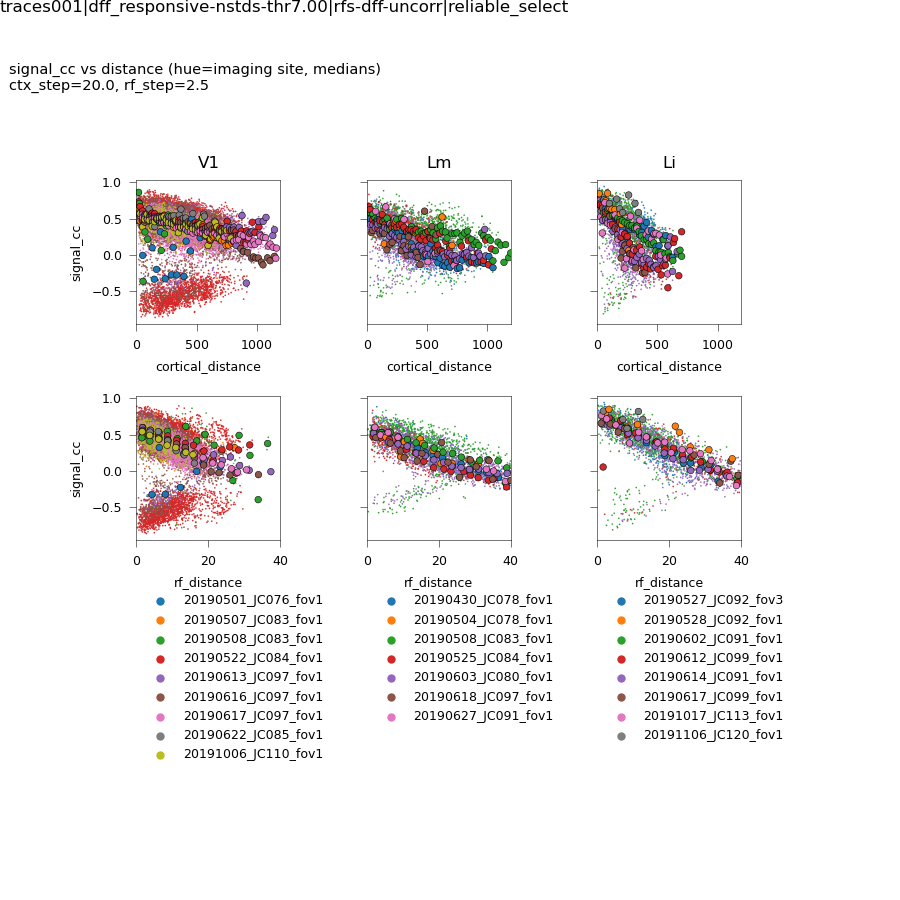

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics decay-fit_signal_cc_dist-metrics_hue-FOV_avgfov


In [315]:
fig, axn = pl.subplots(2, 3, figsize=(6,6), dpi=150, sharex=False, sharey=True)
# vg = df[df.visual_area=='Lm'].copy()

for va, vg in df.groupby('visual_area'):
    for ri, dist_var in enumerate(['cortical_distance', 'rf_distance']):
        ax=axn[ri, visual_areas.index(va)]
        # plot
        x_var = '%s_label' % dist_var
        curr_maxdist = dist_lut[dist_var]['max_dist']
        cnt_groups = [x_var, 'datakey'] if fit_sites else [x_var]

        meas_cc = vg.groupby([x_var, 'datakey']).median().reset_index() #.dropna()
        hue_order = sorted(vg['datakey'].unique(),key=hutils.natural_keys)
        sns.scatterplot(x=dist_var, y=metric, data=vg, ax=ax, 
                        hue='datakey', hue_order=hue_order, edgecolor=None, 
                        s=0.5, legend=None)
        sns.scatterplot(x=dist_var, y=metric, data=meas_cc, ax=ax, 
                        hue='datakey', hue_order=hue_order, edgecolor='k', 
                        s=10, legend=ri==1)
        ax.set_xlim([0, curr_maxdist])
        if ri==0:
            ax.set_title(va)
        if ri==1:
            ax.legend(bbox_to_anchor=(0, -0.3), loc='upper left', frameon=False, 
                         markerscale=0.5, fontsize=6)
            ax.set_xlim([0, 40])    
        ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.4, right=0.85, hspace=0.5, top=0.8)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.9, '%s vs distance (hue=imaging site, medians)\nctx_step=%.1f, rf_step=%.1f' \
             % (metric, ctx_step, rf_step), 
         fontsize=7)

figname = 'decay-fit_%s_dist-metrics_hue-FOV_%s' % (metric, fit_str)
pl.savefig(os.path.join(dst_dir, '%s.svg'% figname))
print(dst_dir, figname)

# Fit by site

In [316]:
dk_lut = dict((va, dict((v, i) for i, v in enumerate(vg['datakey'].unique()))) \
     for va, vg in df.groupby('visual_area'))
     
for va, vg in df.groupby('visual_area'):
    df.loc[vg.index, 'site_num'] = [dk_lut[va][k] for k in vg['datakey'].values]

In [317]:
dist_vars

['cortical_distance', 'rf_distance']

In [318]:
fit_sites=False
min_npairs=10 # N pairs PER BIN
min_npoints=5
too_few_pairs = dict((k, []) for k in visual_areas)
r_list = []
for dist_var in dist_vars:
    x_var = '%s_label' % dist_var
    print(dist_var)
    cnt_groups = [x_var, 'datakey'] if fit_sites else [x_var]
    for (va, dk), df_ in df.groupby(['visual_area', 'datakey']):
        # fit
        nsamples_per = cr.count_nsamples_per_bin(df_, cnt_groups, 
                                                 min_npairs=min_npairs)
        if len(nsamples_per)<min_npoints:
            # print("    no samples, %s, %s" % (va, dk))
            too_few_pairs[va].append(dk)
            continue
        res_, xvals, yvals = cr.sample_bins_and_fit(df_, nsamples_per, cnt_groups, 
                                        to_quartile=dist_var, metric=metric, 
                                        use_binned=use_binned, normalize_x=True, 
                                        func='halflife', estimator='median', 
                                        resample=False)
        res_['visual_area'] = va
        res_['datakey'] = dk
        res_['site_num'] = float(df_['site_num'].unique())
        res_['distance'] = dist_var
        res_['n_pairs'] = len(df_['neuron_pair'].unique())
        r_list.append(res_)
fov_results = pd.concat(r_list, axis=1, ignore_index=True).T
cols = [k for k in fov_results.columns if k \
        not in ['visual_area', 'datakey', 'distance']]
for c in cols:
    fov_results[c] = fov_results[c].astype(float)

cortical_distance
rf_distance


In [319]:
too_few_pairs

{'V1': ['20190501_JC076_fov1',
  '20190508_JC083_fov1',
  '20190501_JC076_fov1',
  '20190622_JC085_fov1'],
 'Lm': ['20190504_JC078_fov1',
  '20190618_JC097_fov1',
  '20190627_JC091_fov1',
  '20190504_JC078_fov1',
  '20190618_JC097_fov1',
  '20190627_JC091_fov1'],
 'Li': ['20190528_JC092_fov1',
  '20190617_JC099_fov1',
  '20191017_JC113_fov1',
  '20191106_JC120_fov1',
  '20190528_JC092_fov1',
  '20190617_JC099_fov1',
  '20191017_JC113_fov1',
  '20191106_JC120_fov1']}

In [320]:
pass0 = pd.concat([g for (va, dk), g in fov_results.groupby(['visual_area', 'datakey']) 
            if dk not in too_few_pairs[va]])
pass_results = pass0[(pass0.R2>0.5) & (pass0.R2<1)].copy()

<IPython.core.display.Javascript object>


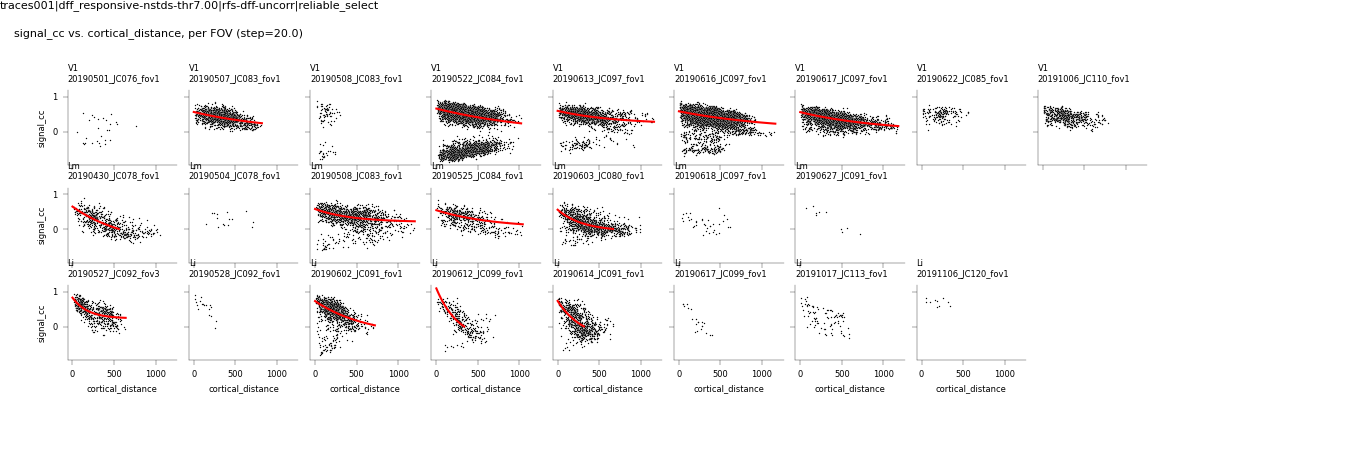

BINNED, no fit: V1
BINNED, no fit: V1
BINNED, no fit: V1
BINNED, no fit: V1
BINNED, no fit: Lm
BINNED, no fit: Lm
BINNED, no fit: Lm
BINNED, no fit: Li
BINNED, no fit: Li
BINNED, no fit: Li
BINNED, no fit: Li
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics decay-fit_each-site_signal_cc_v_cortical_distance


<IPython.core.display.Javascript object>


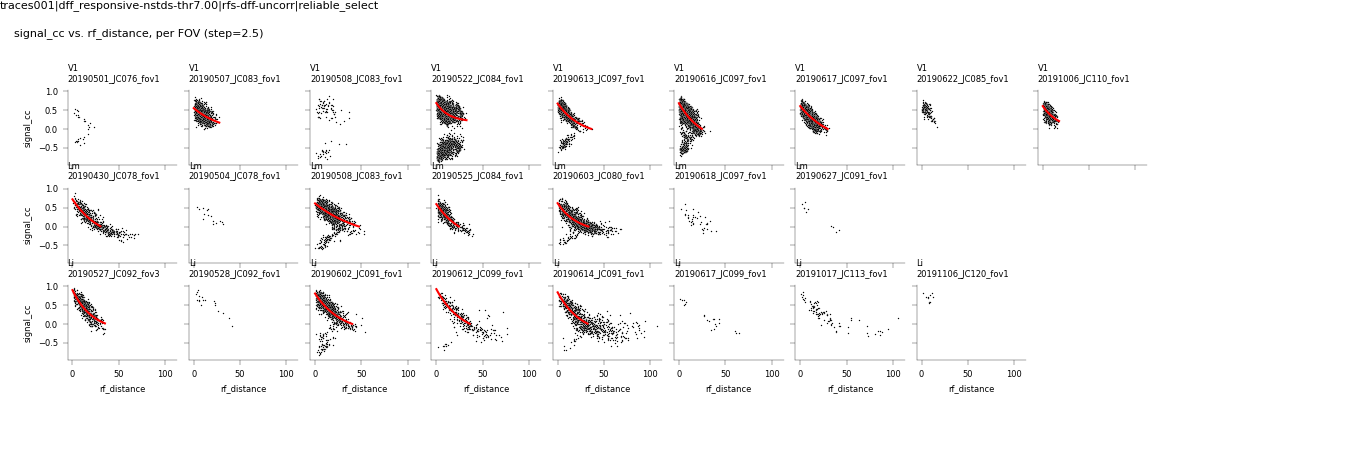

BINNED, no fit: V1
BINNED, no fit: V1
BINNED, no fit: V1
BINNED, no fit: Lm
BINNED, no fit: Lm
BINNED, no fit: Lm
BINNED, no fit: Li
BINNED, no fit: Li
BINNED, no fit: Li
BINNED, no fit: Li
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics decay-fit_each-site_signal_cc_v_rf_distance


In [321]:
#dist_var='rf_distance'
for dist_var in dist_vars:
    x_var = '%s_label' % dist_var
    dist_step =  dist_lut[dist_var]['step']
    curr_maxdist = dist_lut[dist_var]['max_dist']
    cnt_groups = [x_var, 'datakey'] if fit_sites else [x_var]
    #
    fg = sns.FacetGrid(data=df, row='visual_area', row_order=visual_areas,
                       col='site_num', height=1.5, aspect=1)
    fg.map(sns.scatterplot, dist_var, metric, s=1, color='k')
    fg.set_titles('{row_name}|{col_name}')
    for ax in fg.fig.axes:
        va, dnum = ax.get_title().split('|')
        dks = [k for k, v in dk_lut[va].items() if v==float(dnum)]
        if len(dks)==0:
            ax.axis('off')
            ax.set_title('')
            continue
        dk=dks[0]
        ax.set_title('')
        ax.set_title('%s\n%s' % (va, dk), loc='left', fontsize=6)
        curr_res = pass_results[(pass_results.visual_area==va) 
                          & (pass_results.datakey==dk) 
                          & (pass_results.distance==dist_var)].copy()
        if len(curr_res)==0:
            print("BINNED, no fit: %s" % va)
            label='no fit'
        else:
            df_ = df[(df.visual_area==va) & (df.datakey==dk)].copy()
            curr_xmin = df_[x_var].max()+dist_lut[dist_var]['step']
            xvals = np.linspace(0, curr_xmin, 100)
            res_ = pd.Series(curr_res.iloc[0])            
            fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
            valid_ = np.array([i for i, v in enumerate(fit_y) if v>=0])
            label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                            % (va, res_.tau, res_.init, res_.constant, res_.R2)
            ax.plot(xvals[valid_], fit_y[valid_], color='r', label=label)
    pl.subplots_adjust(left=0.05, right=0.85, bottom=0.2, top=0.8,hspace=0.3)
    fg.fig.text(0.01, 0.92, '%s vs. %s, per FOV (step=%.1f)' \
                % (metric, dist_var, dist_step), fontsize=8)
    pplot.label_figure(fg.fig, data_id)
    figname = 'decay-fit_each-site_%s_v_%s' % (metric, dist_var)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

<IPython.core.display.Javascript object>


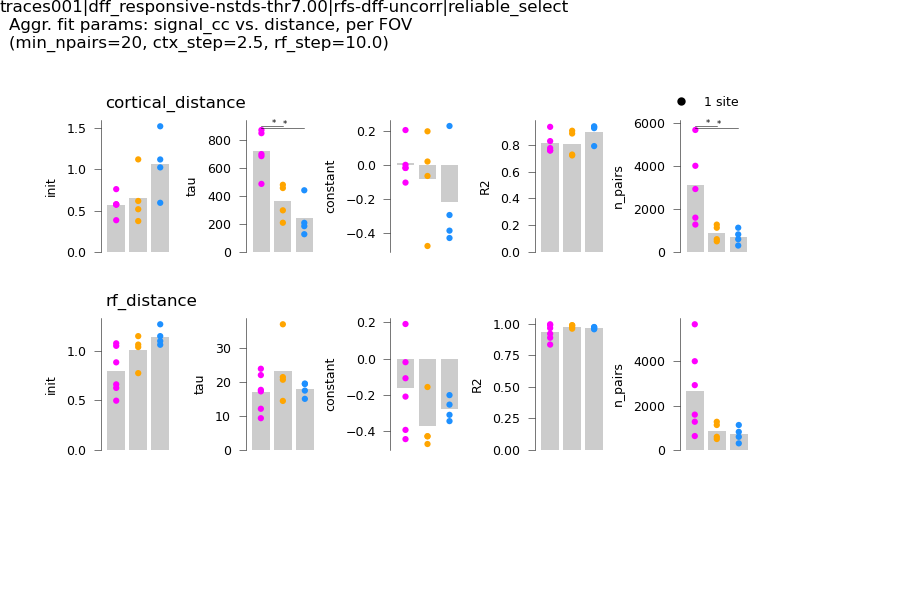

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics decay-fit_each-site_signal_cc_v_rf_distance_aggr-params


In [322]:
plot_params = ['init', 'tau', 'constant', 'R2', 'n_pairs']
dist_vars = ['cortical_distance', 'rf_distance']

fig, axn = pl.subplots(2, len(plot_params), figsize=(6,4), dpi=150)
for ri, (dist_var, df_) in enumerate(pass_results.dropna().groupby('distance')):
    for ci, param in enumerate(plot_params):
        ax=axn[ri, ci]
        y_loc= np.ceil(df_[param].max())
        offset = y_loc/100.
        pplot.stripplot_metric_by_area(df_, ax=ax, metric=param, markersize=3,
                            area_colors=area_colors, posthoc='fdr_bh',
                            y_loc=y_loc+offset, offset=offset, #ylim=(0, 1.03),
                            aspect=2, sig_fontsize=4, jitter=False,
                            return_stats=True, plot_means=True,
                            mean_style='bar', mean_type='mean'   )
        ax.set_xticklabels('')
        if ci==0:
            ax.set_title(dist_var, loc='left', fontsize=8)

ax=axn[0, -1]
leg_h = pplot.custom_legend_markers(colors=['k'], labels=['1 site'],linestyles=''
                               )
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), frameon=False, loc='lower right',
         markerscale=0.5)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.25, top=0.8, wspace=0.5, hspace=0.5)
fig.text(0.01, 0.92, 'Aggr. fit params: %s vs. distance, per FOV\n(min_npairs=%i, ctx_step=%.1f, rf_step=%.1f)' \
                % (metric, ctx_step, rf_step, min_npairs), fontsize=8)

pplot.label_figure(fig, data_id)
# figname = 'each_site_%s_aggr_results' % (metric)
figname = 'decay-fit_each-site_%s_v_%s_aggr-params' % (metric, dist_var)

pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

## Example FOV plot

<IPython.core.display.Javascript object>


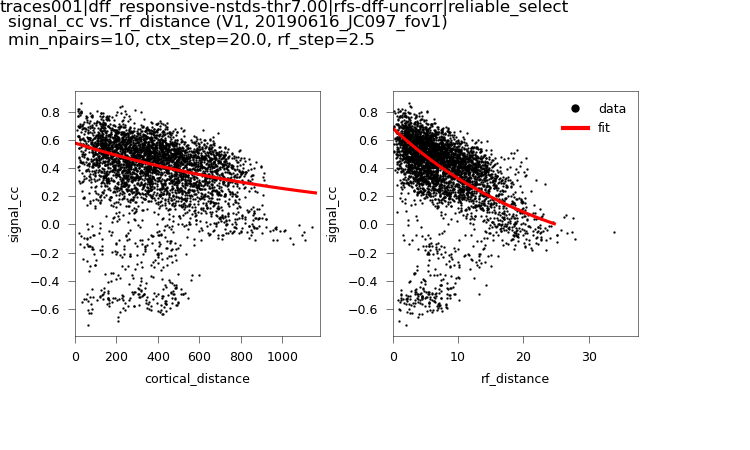

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics/examples decay-fit_each-site_signal_cc_v_rf_distance_example


In [371]:
va='V1'
dk='20190616_JC097_fov1'
fovdf = df[(df.visual_area==va) & (df.datakey==dk)].copy()
fovres = pass_results[(pass_results.visual_area==va) 
                      & (pass_results.datakey==dk)].copy()

fig, axn = pl.subplots(1, 2, figsize=(5,3), dpi=150)

for ci, dist_var in enumerate( ['cortical_distance', 'rf_distance']):
    ax=axn[ci]
    x_var = '%s_label' % dist_var
    # datapoints
    sns.scatterplot(x=dist_var, y=metric, data=fovdf, ax=ax, 
                        edgecolor=None, s=1, legend=None, color='k', alpha=1)
    # fit
    curr_res = fovres[fovres.distance==dist_var].copy()
    stp = dist_lut[dist_var]['step']
    curr_xmax = fovdf[x_var].max()+dist_lut[dist_var]['step']
    xvals = np.linspace(0, curr_xmax, 100)
    res_ = pd.Series(curr_res.iloc[0])            
    fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
    valid_ = np.array([i for i, v in enumerate(fit_y) if v>=0])
    label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                            % (va, res_.tau, res_.init, res_.constant, res_.R2)
    ax.plot(xvals[valid_], fit_y[valid_], color='r', label=label)
    #ax.set_ylim((0,1))
    ax.set_xlim((0, curr_xmax+stp))
    ax.set_box_aspect(1)
    
leg_h = pplot.custom_legend_markers(colors=['k', 'r'],
                                   labels=['data', 'fit'], lws=[0, 2],
                                   linestyles=['', '-'], markers=['o', None])
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper right', frameon=False,
         markerscale=0.5)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.25, top=0.8, wspace=0.3)
fig.text(0.01, 0.9, '%s vs. %s (%s, %s)\nmin_npairs=%i, ctx_step=%.1f, rf_step=%.1f'\
         % (metric, dist_var, va, dk, min_npairs, ctx_step, rf_step), fontsize=8)
pplot.label_figure(fig, data_id)

# label neg corrs?
# plot_posdf = rfs_pos.loc[curr_rois].copy()
# neg_cc_roi_colors = dict((k, v) for k, v in zip(curr_rois, 
#                                 sns.color_palette('hsv', n_colors=len(curr_rois)))) 


# figname = 'rf_%s_vs_distances_EX_%s' % (metric, va)
figname = 'decay-fit_each-site_%s_v_%s_example' % (metric, dist_var)

pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
#pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

print(examples_dir, figname)

## All fits

<IPython.core.display.Javascript object>


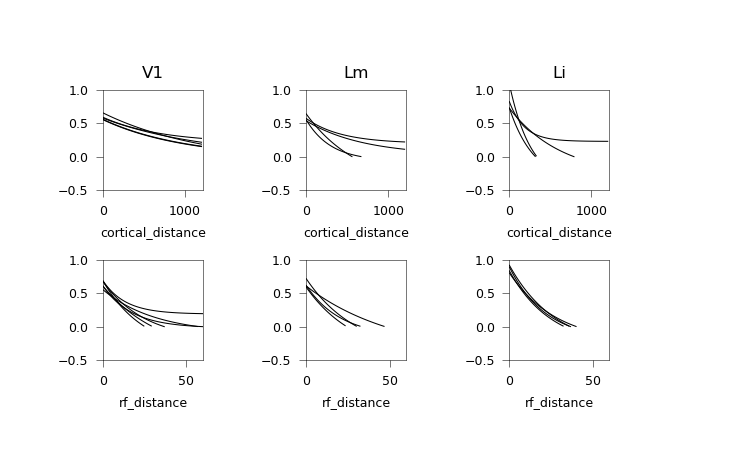

In [404]:
fig, axn = pl.subplots(2, 3, figsize=(5,3), dpi=150)
ylim = (-0.5,1)
df_list=[]
for ri, dist_var in enumerate(dist_vars):
    for (va, dk), vg in pass_results.groupby(['visual_area', 'datakey']):
        ax=axn[ri, visual_areas.index(va)]
        x_var = '%s_label' % dist_var
        # fit
        curr_res = vg[vg.distance==dist_var].copy()
        if len(curr_res)==0:
            continue
        stp = dist_lut[dist_var]['step']
        curr_xmax = df[x_var].max()+dist_lut[dist_var]['step']
        xvals = np.linspace(0, curr_xmax, 100)
        res_ = pd.Series(curr_res.iloc[0])            
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        valid_ = np.array([i for i, v in enumerate(fit_y) if v>=0])
        xv = xvals[valid_]
        yv = fit_y[valid_]
        ax.plot(xv, yv, color='k', lw=0.5)
        
        df_ = pd.DataFrame({'xv': xv, 'fit_y': yv})
        df_['distance_metric'] = dist_var
        df_['visual_area'] = va
        df_['datakey'] = dk
        df_list.append(df_)
        
        ax.set_ylim(ylim)
        if dist_var=='rf_distance':
            ax.set_xlim((0, 60))
        else:
            ax.set_xlim((0, curr_xmax+stp))
        ax.set_box_aspect(1)
        if ri==0:
            ax.set_title(va)
        ax.set_xlabel(dist_var)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.3, 
                   hspace=0.7)

fitv_df = pd.concat(df_list, axis=0, ignore_index=True)


In [375]:
fitv_df.head()

xv     fit_y    distance_metric visual_area              datakey
0   0.000000  0.824566  cortical_distance          Li  20190527_JC092_fov3
1  12.121212  0.786483  cortical_distance          Li  20190527_JC092_fov3
2  24.242424  0.750836  cortical_distance          Li  20190527_JC092_fov3
3  36.363636  0.717469  cortical_distance          Li  20190527_JC092_fov3
4  48.484848  0.686237  cortical_distance          Li  20190527_JC092_fov3

In [393]:
fitv_df[['visual_area', 'datakey']].drop_duplicates().groupby('datakey').count()

visual_area
datakey                         
20190430_JC078_fov1            1
20190507_JC083_fov1            1
20190508_JC083_fov1            1
20190522_JC084_fov1            1
20190525_JC084_fov1            1
20190527_JC092_fov3            1
20190602_JC091_fov1            1
20190603_JC080_fov1            1
20190612_JC099_fov1            1
20190613_JC097_fov1            1
20190614_JC091_fov1            1
20190616_JC097_fov1            1
20190617_JC097_fov1            1
20191006_JC110_fov1            1

In [396]:
dkey_colors = dict((k, area_colors[v]) for (v, k), g\
                   in fitv_df.groupby(['visual_area', 'datakey']))

<IPython.core.display.Javascript object>


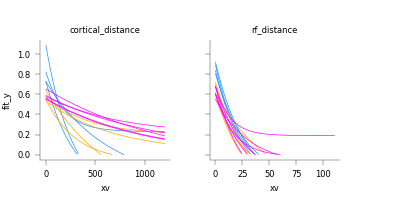

In [400]:
# fg = sns.FacetGrid(data=fitv_df.dropna(), row='distance_metric', row_order=dist_vars,
#                   col='visual_area', col_order=visual_areas, hue='datakey',
#                    sharex=False, height=2)

# fg.map(pl.plot, 'xv', 'fit_y')

fg = sns.FacetGrid(data=fitv_df.dropna(), col='distance_metric', col_order=dist_vars,
                  hue='datakey', palette=dkey_colors,
                   sharex=False, height=2)

fg.map(pl.plot, 'xv', 'fit_y', lw=0.5)
fg.set_titles('{col_name}')

for ax in fg.fig.axes:
    dist_var = ax.get_title()
    for va, vg in fitv_df[fitv_df.distance_metric==dist_var].groupby('visual_area'):
        vg
#         meanv = vg.groupby(['visual_area']).mean().reset_index()
#         stdv =  fitv_df[fitv_df.distance_metric==dist_var]\
#                     .groupby(['visual_area']).std().reset_index()
#         ax.plot(meanx['xv'], meanv['fit_y'], color=

#                 stdv
#         d


pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.3, 
                   hspace=0.7)

In [402]:
vg.groupby('datakey').count()

xv  fit_y  distance_metric  visual_area
datakey                                                      
20190507_JC083_fov1   52     52               52           52
20190522_JC084_fov1  100    100              100          100
20190613_JC097_fov1   34     34               34           34
20190616_JC097_fov1   23     23               23           23
20190617_JC097_fov1   27     27               27           27
20191006_JC110_fov1   55     55               55           55

In [310]:
cnts_lut_ = dict((k[0], v) for k, v in nsamples_per.items())
df_['n_pairs'] = [cnts_lut_[i] if i in list(cnts_lut_.keys()) else np.nan\
                  for i in df_[x_var].values]

In [311]:
meds_ = df_.groupby([x_var]).median().reset_index()

<IPython.core.display.Javascript object>


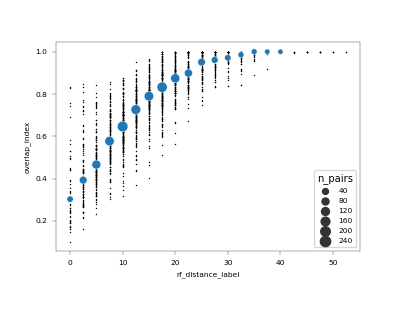

In [313]:
fig, ax = pl.subplots()

sns.scatterplot(x=x_var,y=metric, data=df_, ax=ax, s=1,
                color='k', edgecolor=None)

sns.scatterplot(x=x_var,y=metric, data=meds_, ax=ax, size='n_pairs')

pl.subplots_adjust(bottom=0.3, right=0.8)

In [200]:
dist_lut

{'cortical_distance': {'bins': array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
         110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
         220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
         330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,
         440., 450., 460., 470., 480., 490., 500.]),
  'step': 10,
  'max_dist': 500.0},
 'rf_distance': {'bins': array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
          11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
          22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
          33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
          44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
          55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
          66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
          77.,  78.,  79.,  80.,  

# Bootstrap decay fit

In [287]:
equal_bins=False
n_bins=10

# ctx_maxdist=800
# df, dist_lut = cr.get_bins_and_cut(DISTS[DISTS.cortical_distance<=ctx_maxdist].dropna(),
#                                    ctx_step=20, overlap_step=0.1, rf_step=5, 
#                                    equal_bins=False)

equal_bins=False
n_bins=10

ctx_maxdist=1200
df, dist_lut = cr.get_bins_and_cut(DISTS[DISTS.cortical_distance<=ctx_maxdist].dropna(),
                                   ctx_step=20, overlap_step=0.1, rf_step=2.5,
                                   equal_bins=False)

In [296]:
use_binned = False # Average the values in each bin, then fit.
fit_sites = True # Only average within-animal
use_quartile=False
metric='signal_cc'
to_quartile='rf_distance'
dist_step = dist_lut[to_quartile]['step']
# --------------------------------------------------
ymax = 1 if metric=='area_overlap' else None

cut_str = 'qcut' if use_quartile else 'cut'
bin_str = 'fitbin' if use_binned else 'fitraw'
fit_str = 'avgfov' if fit_sites else 'cellpairs' 
bin_type = '%s-%s-%s' % (cut_str, bin_str, fit_str)
print('Fitting: %s' % bin_type)
n_iterations=500
# Fit function
resdf = cr.bootstrap_fitdecay(df.dropna(), use_binned=use_binned, 
                         fit_sites=fit_sites, min_npairs=5,
                         metric=metric, to_quartile=to_quartile,
                         normalize_x=True, ymax=ymax, resample=True,
                         n_iterations=n_iterations)
for p in ['R2', 'init', 'tau', 'constant']:
    resdf[p] = resdf[p].astype(float)
print(resdf[resdf['R2']>0.5].shape)

Fitting: cut-fitraw-avgfov
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    v

    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val ou

init: 0/500 iters too big
init: 0/500 iters too small
tau: 0/500 iters too big
tau: 0/500 iters too small


<IPython.core.display.Javascript object>


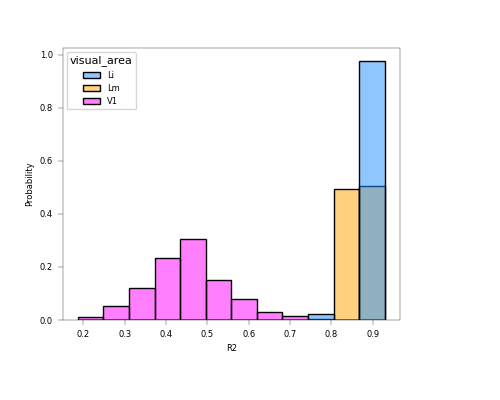

In [297]:
ymin, ymax = (-1, 1+0.2)
xmin, xmax = (0, dist_lut[to_quartile]['max_dist'])
# ------------------------------------------------
resdf = resdf[resdf.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]

print("init: %i/%i iters too big" % (resdf[resdf.init>ymax].shape[0], n_iterations))
print("init: %i/%i iters too small" % (resdf[resdf.init<ymin].shape[0], n_iterations))

print("tau: %i/%i iters too big" % (resdf[resdf.tau>xmax].shape[0], n_iterations))
print("tau: %i/%i iters too small" % (resdf[resdf.tau<xmin].shape[0], n_iterations))

fig, ax =pl.subplots()
sns.histplot(x='R2', data=resdf.dropna(), ax=ax, hue='visual_area', 
             palette=area_colors, stat='probability', common_norm=False)
pl.subplots_adjust(bottom=0.2, right=0.8)

In [298]:
resdf = resdf[resdf.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
if use_binned:
    print("is binned, checking R2")
    finalres = resdf[(resdf['init']<=ymax+0.2) & (resdf['init']>=ymin-0.2) 
                   & (resdf['tau']<=xmax) & (resdf['tau']>=xmin)
                   & (resdf['R2']>0.5)].copy().dropna()
else:
    finalres = resdf[(resdf['init']<=ymax) & (resdf['init']>=ymin) 
                   & (resdf['tau']<=xmax) & (resdf['tau']>=xmin)].copy().dropna()
                   #& (resdf['R2']>0.5)].copy()
print(resdf.shape, finalres.shape)

(1042, 6) (1042, 6)


In [299]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

RF distance (deg)


<IPython.core.display.Javascript object>


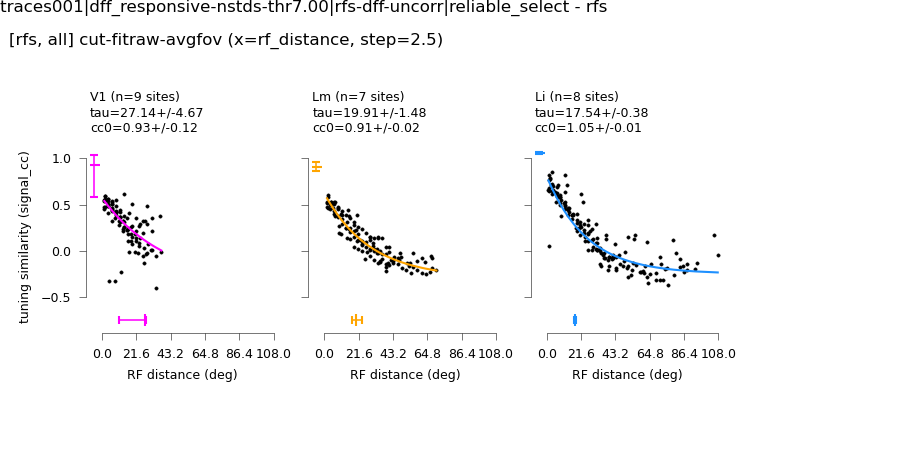

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics boot-decay-fit_curves_rf_distance_v_signal_cc_all


In [300]:

select_stimuli='all'
if xmax==1:
    x_pos = xmin-0.1
    xlabel='%s (frac.)' % to_quartile
else:
    x_pos = -100 if to_quartile=='cortical_distance' else -5
    xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
y_pos = ymin+0.25
ylabel='tuning similarity (%s)' % metric
xlim=(x_pos+(x_pos*0.5), dist_lut[to_quartile]['max_dist']+1) #(ymin-0.2, ymax+0.4)

print(xlabel)
use_best_r2=False
fig = cr.plot_fit_distance_curves(df, finalres,  metric=metric, 
                            to_quartile=to_quartile, 
                            use_best_r2=use_best_r2, fit_sites=fit_sites,
                            area_colors=area_colors, 
                            x_pos=x_pos, y_pos=-0.75,elinewidth=0.75,
                            xlim=xlim, ylim=None, xlabel=xlabel, ylabel=ylabel)
fig.text(0.01, 0.9, '[%s, %s] %s (x=%s, step=%.1f)' \
    % (experiment, select_stimuli, bin_type, to_quartile, dist_step), fontsize=8)
xticks = np.linspace(0, dist_lut[to_quartile]['max_dist'], 6)
for ax in fig.axes:
    ax.set_xticks(xticks)
sns.despine(trim=True, offset=2)
pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
figname = 'boot-decay-fit_curves_%s_v_%s_%s' % (to_quartile, metric, select_stimuli)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [301]:
for va, vg in finalres.groupby('visual_area'):
    print('%s --------------------' % va)
    print(vg.describe())

Li --------------------
            init        tau   constant         R2
count  42.000000  42.000000  42.000000  42.000000
mean    1.053020  17.590272  -0.246158   0.905063
std     0.008060   0.375118   0.009601   0.022871
min     1.042030  16.863608  -0.272266   0.776966
25%     1.046025  17.356748  -0.250239   0.903675
50%     1.054866  17.544154  -0.246427   0.909619
75%     1.057453  17.756888  -0.239707   0.914655
max     1.069536  18.616607  -0.225094   0.929143
Lm --------------------
             init         tau    constant          R2
count  500.000000  500.000000  500.000000  500.000000
mean     0.912793   20.025288   -0.289775    0.866626
std      0.024364    1.481418    0.030175    0.012722
min      0.848693   16.155915   -0.410937    0.801305
25%      0.896419   19.024130   -0.306665    0.859321
50%      0.911189   19.905112   -0.289008    0.867539
75%      0.929070   20.853752   -0.269159    0.875306
max      1.001549   25.964328   -0.213585    0.896757
V1 -------------

<IPython.core.display.Javascript object>


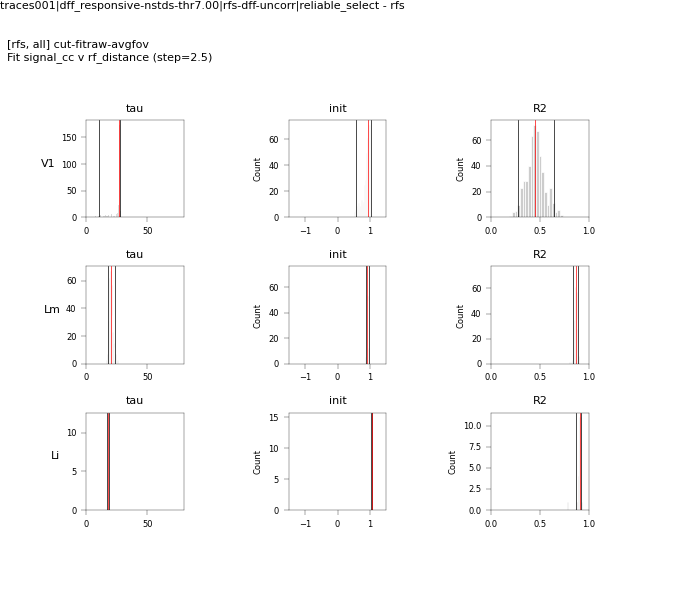

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics boot-decay-fit_paramCIs_rf_distance_v_signal_cc_all


In [304]:
if to_quartile=='area_overlap':
    tau_lim = 1.5
else:
    tau_lim=1200 if to_quartile=='cortical_distance' else 80
fig, axn = pl.subplots(3,3, figsize=(6.75,6))
fig.patch.set_alpha(1)

for va, rd_ in resdf.dropna().groupby('visual_area'):
    for pi, param in enumerate(['tau', 'init', 'R2']):
        ax=axn[visual_areas.index(va), pi]
        sns.histplot(x=param, data=rd_, ax=ax, color=[0.8]*3, 
                    edgecolor='w', stat='count', alpha=1)
        ci_lo, ci_hi = hutils.get_empirical_ci(rd_[param].values)
        ax.axvline(x=ci_lo, color='k', lw=0.5)
        ax.axvline(x=ci_hi, color='k', lw=0.5)
        med = rd_[param].median()
        ax.axvline(x=med, color='r', lw=0.5)
        ax.set_title(param)
        ax.set_xlabel('')
        if param=='tau':
            ax.set_xlim([0, tau_lim])
        elif param=='init':
            ax.set_xlim([-1.5, 1.5])
        elif param=='R2':
            ax.set_xlim([0, 1])
        ax.set_box_aspect(1)
    axn[visual_areas.index(va), 0].set_ylabel(va, fontsize=8, rotation=0, ha='right')
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, hspace=0.5, wspace=0.5, top=0.8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
fig.text(0.01, 0.9, '[%s, %s] %s\nFit %s v %s (step=%.1f)' \
    % (experiment, select_stimuli, bin_type, metric, to_quartile, dist_step), 
         fontsize=8)


figname = 'boot-decay-fit_paramCIs_%s_v_%s_%s' % (to_quartile, metric, select_stimuli)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [192]:
# dist_var='cortical_distance'
# ctx_maxdist=1200
# ctx_step=25
# ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)

# rf_maxdist=60
# rf_step=5
# rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)

# dist_bins = copy.copy(ctx_bins) if dist_var=='cortical_distance' \
#                 else copy.copy(rf_bins)

# diffs = cr.cut_bins(diffs, dist_bins, dist_var)

# grp_step=100 if dist_var=='cortical_distance' else 15
# grp_max = 1000 if dist_var=='cortical_distance' else 60
# grp_bins = np.arange(0, grp_max+grp_step, grp_step)
# diffs['group_value'] = pd.cut(diffs[dist_var], grp_bins, 
#                             include_lowest=True, labels=grp_bins[0:-1])
# diffs['group_label'] = [int(d) if not np.isnan(d) else d \
#                              for d in diffs['group_value'].values]

In [242]:
import pingouin as pg

In [243]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics'

In [244]:
# experiment = 'rfs'
# responsive_test='nstds'
# trial_epoch='stimulus'
# # ----------------------------------------------------------------
# response_type='dff'
# responsive_thr=7.0 if experiment=='rfs' else 10.
# n_stds=2.5
# n_bootstrap_iters=500
# print(responsive_test, responsive_thr)
# # Responsive params
# resp_desc = '%s_responsive-%s-thr%.2f' \
#                 % (response_type, responsive_test, responsive_thr)
# data_id = '|'.join([traceid, resp_desc])
# print(data_id)
# #### Load all metdata and assigned cells
# sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
# meta = sdata[sdata.experiment.isin(experiment_list)].copy()
# #### Output dir
# cc_dir = os.path.join(aggregate_dir, 'correlations', 
#                        '%s_%s_%s' % (experiment, response_type, responsive_test))
# if not os.path.exists(cc_dir):
#     os.makedirs(cc_dir)
# print(cc_dir)

In [469]:
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in rf_ukeys], ignore_index=True)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl


In [471]:
finaldf['experiment'].unique()

array(['rfs10', 'rfs'], dtype=object)

In [246]:
select_stimuli='fullfield'
distance_var = 'rf_distance'
min_ncells=10
CORRS = cr.aggregate_ccdist(NDATA, experiment=experiment, rfdf=rfdf,
                        SDF=None, select_stimuli=select_stimuli,min_ncells=min_ncells,
                        distance_var=distance_var, verbose=True)

Dist: rf_distance
0 datasets w wrong configs:
0 datasets w/out RF fits:


In [247]:
CORRS.head()

cell_1  cell_2  signal_cc neuron_pair  noise_cc  rf_distance    max_ecc  \
0       1       2   0.722867         1_2  0.194088     9.843133  29.971839   
1       1       4   0.612922         1_4  0.012481     3.956535  29.339362   
2       1       5   0.603857         1_5  0.168463     4.544876  29.339362   
3       1       9   0.370799         1_9  0.083089     8.273882  29.339362   
4       1      14   0.498955        1_14  0.059313     3.166283  29.339362   

     min_ecc  cortical_distance visual_area              datakey experiment  \
0  29.339362          31.138301          Li  20190527_JC092_fov3        rfs   
1  28.662374          69.239792          Li  20190527_JC092_fov3        rfs   
2  26.675416          41.847749          Li  20190527_JC092_fov3        rfs   
3  21.579561          98.959469          Li  20190527_JC092_fov3        rfs   
4  26.519261          70.586142          Li  20190527_JC092_fov3        rfs   

   n_cells  
0       65  
1       65  
2       65  
3       65  
4       65

In [248]:
CORRS.shape, CORRS.dropna().shape

((202626, 13), (29068, 13))

In [249]:
DISTS.columns

Index(['neuron_pair', 'cell_1', 'cell_2', 'rf_angle_diff', 'rf_angle_diff_abs',
       'std_x', 'std_y', 'aspect_ratio', 'rf_distance', 'max_ecc', 'min_ecc',
       'cortical_distance', 'area_overlap', 'perc_overlap', 'visual_area',
       'datakey', 'n_cells'],
      dtype='object')

In [250]:
CORRS.columns

Index(['cell_1', 'cell_2', 'signal_cc', 'neuron_pair', 'noise_cc',
       'rf_distance', 'max_ecc', 'min_ecc', 'cortical_distance', 'visual_area',
       'datakey', 'experiment', 'n_cells'],
      dtype='object')

In [287]:
ign_cols =  ['experiment', 'signal_cc', 'noise_cc', 'n_cells']
cc_cols = [k for k in CORRS.columns if k not in ign_cols]
DF = pd.merge(DISTS, CORRS, on=cc_cols, how='inner')

<IPython.core.display.Javascript object>


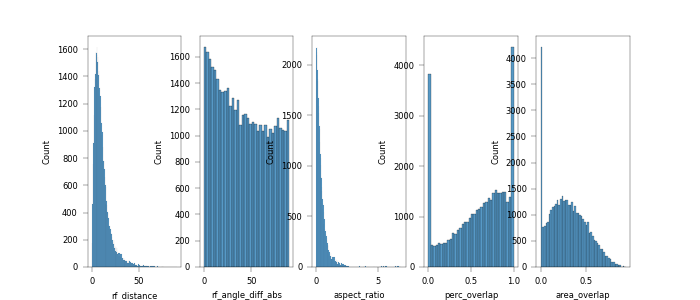

In [296]:
plot_params = ['rf_distance', 'rf_angle_diff_abs', 'aspect_ratio',
               'perc_overlap', 'area_overlap']

fig, axn = pl.subplots(1, len(plot_params), figsize=(7,3))
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=DF, ax=ax)

In [317]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [318]:
ctx_step=20
max_dist=1200
df = DF[DF.cortical_distance<=max_dist].copy()

ctx_dist_bins = np.arange(0, max_dist+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_dist_bins, metric='cortical_distance')

metric = 'rf_angle_diff_abs'
m_bins = np.linspace(0, 90, 13)
df = cr.cut_bins(df, m_bins, metric=metric)

metric = 'aspect_ratio'
step = 0.5
m_bins = np.linspace(0, 3, 30)
df = cr.cut_bins(df, m_bins, metric=metric)

metric = 'perc_overlap'
m_bins = np.linspace(0, 1, 10)
df = cr.cut_bins(df, m_bins, metric=metric)

metric = 'area_overlap'
m_bins = np.linspace(0, 1, 10)
df = cr.cut_bins(df, m_bins, metric=metric)


In [319]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

<IPython.core.display.Javascript object>


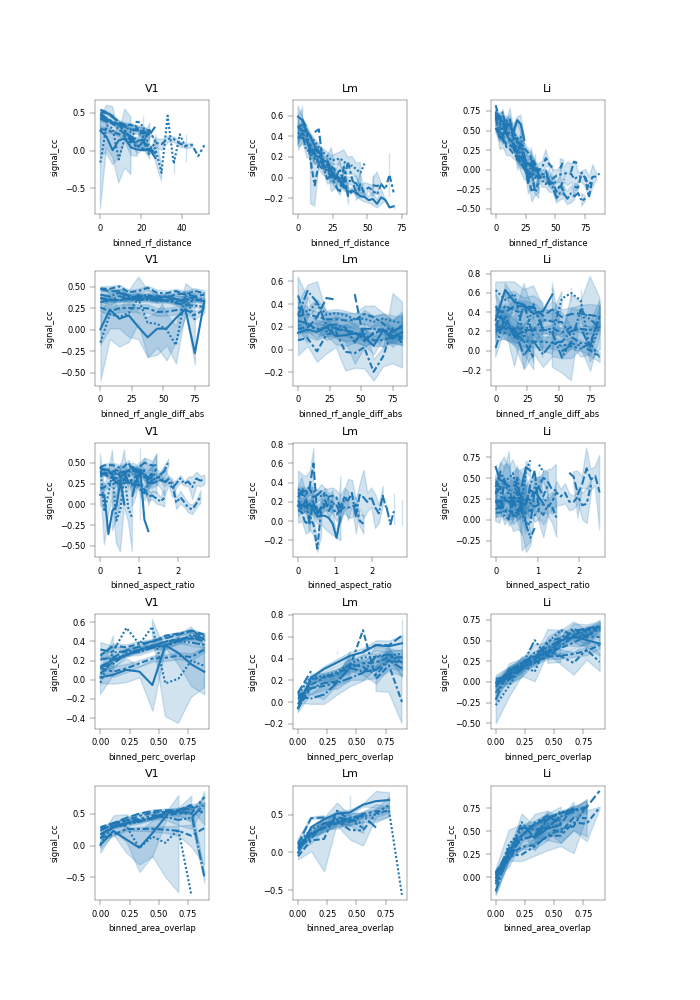

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [320]:
y_var = 'signal_cc'
y_var = 'signal_cc'

plot_params = ['rf_distance', 'rf_angle_diff_abs', 'aspect_ratio',
               'perc_overlap', 'area_overlap']

fig, axn = pl.subplots(len(plot_params),3, figsize=(7,10))
for ri, par in enumerate(plot_params):
    for va, vg in df.groupby('visual_area'):
        vi = visual_areas.index(va)
        ax=axn[ri, vi]
        ax.set_title(va)
        sns.lineplot(x='binned_%s' % par, y=y_var, ax=ax, data=vg,
                    style='datakey')
        ax.legend_.remove()
        ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, hspace=0.5, top=0.9)

In [ ]:
rf_angle_diff_abs

## Overlap v. distance

In [ ]:
# Bin cortical distances for plotting
n_bins_dist = 6
n_bins_overlap = 6

use_quartile=False
bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    finaldf['binned_dist'], bin_edges = pd.qcut(finaldf['cortical_distance'], \
                                    n_bins_dist, labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    finaldf['binned_dist'], bin_edges = pd.cut(finaldf['cortical_distance'], \
                                     n_bins_dist,labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)

In [235]:
meanf = finaldf.groupby(['visual_area', 'datakey', 'experiment', 'binned_dist'])\
                .mean().reset_index()

<IPython.core.display.Javascript object>


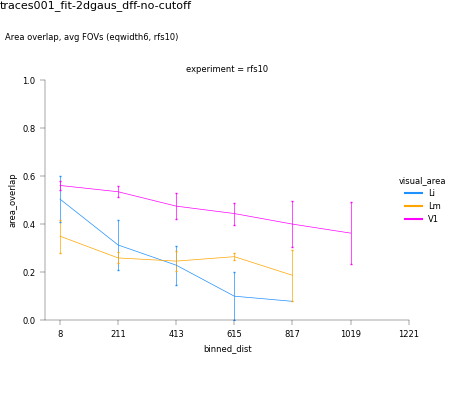

In [236]:
lw=0.5
metric='area_overlap'
fg = sns.relplot(x='binned_dist', y='area_overlap', hue='visual_area',
                 data=meanf, ci='sd', col='experiment', err_style='bars',
                 kind='line', height=4, palette=area_colors,
                 err_kws={'capsize':1, 'lw': lw}, lw=lw)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, 'Area overlap, avg FOVs (%s, %s)' % (bin_type, rf_type))

pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.ylim([0, 1])
p3.label_figure(fg.fig, data_id)

figname =  '%s_by_dist_%s__%s' % (metric, bin_type, rf_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


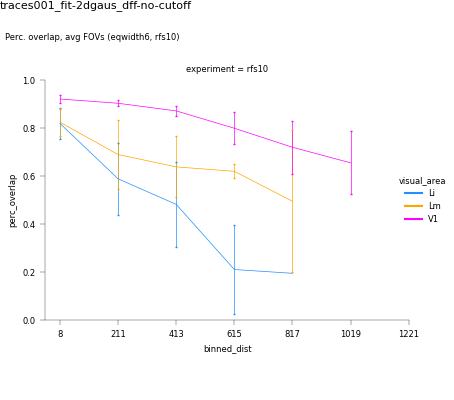

In [237]:
metric='perc_overlap'
fg = sns.relplot(x='binned_dist', y=metric, hue='visual_area',
                 data=meanf, ci='sd', col='experiment', err_style='bars',
                 kind='line', height=4, palette=area_colors,
                err_kws={'capsize':1, 'lw': lw}, lw=lw)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, 'Perc. overlap, avg FOVs (%s, %s)' % (bin_type, rf_type))

pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.ylim([0, 1])
p3.label_figure(fg.fig, data_id)

figname =  '%s_by_dist_%s__%s' % (metric, bin_type, rf_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


<IPython.core.display.Javascript object>


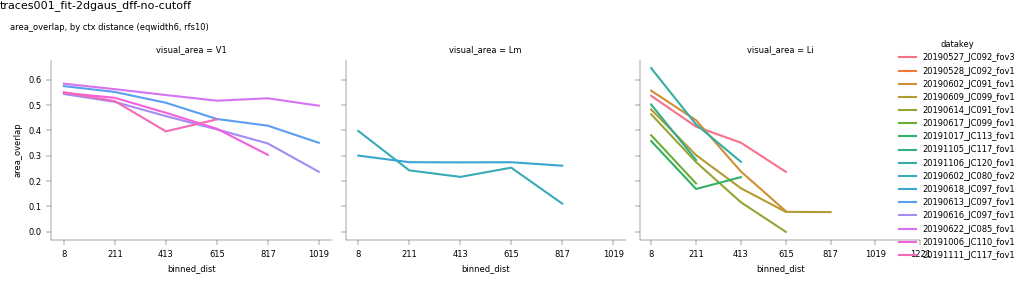

In [240]:
# fig, ax = pl.sublots()
metric = 'area_overlap'
fg = sns.relplot(x='binned_dist', y=metric, hue='datakey',
                 data=meanf,col='visual_area', col_order=visual_areas,
                 kind='line', height=3)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, '%s, by ctx distance (%s, %s)' % (metric, bin_type, rf_type))
pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.subplots_adjust(left=0.05, right=0.9)
# fg.axes.flat[0].legend_.remove()
p3.label_figure(fg.fig, data_id)

figname =  'perFOV_%s_by_dist_%s__%s' % (metric, bin_type, rf_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


<IPython.core.display.Javascript object>


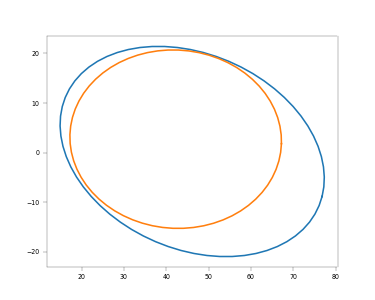

In [256]:
# fig, ax = pl.subplots()
# ax.plot(*rf_polys[4].exterior.xy)
# ax.plot(*rf_polys[11].exterior.xy)


In [ ]:
# # Convert stimuli to polyon bounding boxes
# stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
#               for blob_sz in stim_sizes[experiment]]